# **PERFORMANCE OF BNTP TRADING STRATEGY ON GBPUSD(cable) OVER A ONE YEAR PERIOD**

## **1. PROBLEM STATEMENT**   
This project aims to conduct a comprehensive performance analysis of a personal forex trading strategy applied to the GBPUSD currency pair _(also cable or GU)_ over a one year trading period. The strategy dubbed BNTP(Bias Narrative Time Price) was personally developed based on the renowned ICT (Inner Circle Trader) concepts in the retail trading space. The primary objective is to determine the strategy's profitability and reliability to inform future trading decisions based on Key Metrics.

The core problem is to empirically validate the effectiveness of the trading strategy and identify the specific conditions under which it is most profitable and reliable. The final analysis will provide actionable insights into the strategy's strengths and weaknesses, enabling a data-driven conclusion on its long-term viability. The outcome will serve as a foundational guide for optimizing the strategy's parameters and developing robust risk management protocols and time windows to support a solid strategy best suited for trade execution.

## **2. DATA COLLECTION**  
The data for the project was stored in a local instance of MySQL database.  
Appropriate steps required for extracting this first-party data from the database will be implemented.

In [2]:
# import required libraries
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from typing import Union, List, Dict, Any, Optional
from scipy.stats import zscore

from pandas.api.types import is_datetime64_any_dtype, is_object_dtype, is_string_dtype,is_numeric_dtype

In [75]:
from sklearn.preprocessing import MinMaxScaler
from math import pi

In [3]:
# Define database connection parameters
config = {
    'host': 'localhost',
    'user': 'root',
    'password': '1nyxriC!',
    'database': 'forex_journal',
    'port': 3306
}

In [4]:
# Connect to MySQL Database (forex_journal database specified)
connection = pymysql.connect(**config)

In [5]:
# Create a cursor object
cursor = connection.cursor()

In [6]:
# Retrieve Tables in the Database
cursor.execute("SHOW TABLES")

for table in cursor:
    print(table)

('daily_candle_data',)
('psychology',)
('risk_management',)
('trade',)


In [7]:
# Join tables
query = """
        SELECT * FROM trade t
        JOIN risk_management r
        ON t.trade_id = r.trade_id
        WHERE t.asset = 'cable'
        """

In [8]:
# Retrieve data from the joined tables
cursor.execute(query)

cable_data = cursor.fetchall()

In [9]:
# Get column names
column_names = [column[0] for column in cursor.description]
column_names

['Trade_id',
 'Trade_open',
 'Trade_close',
 'Session',
 'Asset',
 'Position',
 'Bias',
 'Profile',
 'Entry',
 'Confirmation',
 'Fvg_level',
 'Risk_id',
 'Trade_id',
 'Stop_loss_pips',
 'Take_profit_pips',
 'Risk_to_reward',
 'Risk_usd',
 'Profit_loss',
 'Trail_stop',
 'Outcome',
 'Balance']

In [10]:
# Create DataFrame from fetched data
dataframe = pd.DataFrame(data=cable_data, columns=column_names)

## **3. DATA CLEANING**  
This phase aims at performing quality checks, removing unnecessary columns and rows, correcting structural errors and fixing data types where necessary.  
Due to the fact that I built the database to collect only needed data most of the data points are as expected and valid for the aim of the analysis.

### **3.1.1 Data Quality Checks**  

The quality of data in each column must be ensured for a good anaylsis.  
Data with poor quality will be corrected to achieve this.

In [12]:
# Function for analysing data characteristics
def data_characteristics(data: Union[pd.DataFrame, pd.Series]) -> None:
    """
    Analyzes and prints key characteristics of a pandas DataFrame or Series.

    This function calculates and displays the following information:
    - The total number of duplicate rows/values.
    - The memory usage of the DataFrame/Series in megabytes (MB).
    - The number of unique values for each column (if a DataFrame) or for the Series itself.

    Args:
        data (pd.DataFrame | pd.Series): The pandas DataFrame or Series to analyze.

    Returns:
        None: This function does not return any value; it prints the characteristics
              directly to the console.

    Raises:
        TypeError: If the input `data` is not a pandas DataFrame or Series.
    """
    if not isinstance(data, (pd.DataFrame, pd.Series)):
        raise TypeError("Input 'data' must be a pandas DataFrame or Series.")

    print("\n--- Data Characteristics ---")

    # Calculate and print the number of duplicate rows/values
    print(f"\nDuplicates: {data.duplicated().sum()}")

    # Return memory usage in MB
    memory_mb = data.memory_usage(deep=True).sum() / (1024**2)
    print(f"\nMemory Usage: {memory_mb:.4f} MB") # Formatted to 4 decimal places

    # Return number of unique values
    print(f"\nUnique Values:\n {data.nunique()}")

In [15]:
# Check data characteristics
data_characteristics(dataframe)


--- Data Characteristics ---

Duplicates: 0

Memory Usage: 0.0769 MB

Unique Values:
 Trade_id            102
Trade_open          102
Trade_close         101
Session               2
Asset                 1
Position              2
Bias                  2
Profile               4
Entry                 2
Confirmation          5
Fvg_level             6
Risk_id             102
Trade_id            102
Stop_loss_pips       21
Take_profit_pips     44
Risk_to_reward       65
Risk_usd             27
Profit_loss          46
Trail_stop            2
Outcome               2
Balance              82
dtype: int64


The data has no duplicates.  
The memory usage is 0.0547 MB which is very low and manageable.  
The number of unique values for each column is as expected.

### **3.1.2 Remove Unnecessary Data**  

Some columns are duplicates and others will be of no significance during analysis.  
Such columns a dropped.

In [13]:
# Return basic information about the DataFrame (detect columns to remove)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Trade_id          102 non-null    int64  
 1   Trade_open        102 non-null    object 
 2   Trade_close       102 non-null    object 
 3   Session           102 non-null    object 
 4   Asset             102 non-null    object 
 5   Position          102 non-null    object 
 6   Bias              102 non-null    object 
 7   Profile           102 non-null    object 
 8   Entry             102 non-null    object 
 9   Confirmation      102 non-null    object 
 10  Fvg_level         51 non-null     float64
 11  Risk_id           102 non-null    int64  
 12  Trade_id          102 non-null    int64  
 13  Stop_loss_pips    102 non-null    float64
 14  Take_profit_pips  102 non-null    float64
 15  Risk_to_reward    102 non-null    float64
 16  Risk_usd          102 non-null    float64
 1

In [11]:
# Drop unnecessary columns
dataframe.drop(columns=['Trade_id', 'Trade_id', 'Risk_id', 'Asset'], inplace=True)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Trade_open        102 non-null    object 
 1   Trade_close       102 non-null    object 
 2   Session           102 non-null    object 
 3   Position          102 non-null    object 
 4   Bias              102 non-null    object 
 5   Profile           102 non-null    object 
 6   Entry             102 non-null    object 
 7   Confirmation      102 non-null    object 
 8   Fvg_level         51 non-null     float64
 9   Stop_loss_pips    102 non-null    float64
 10  Take_profit_pips  102 non-null    float64
 11  Risk_to_reward    102 non-null    float64
 12  Risk_usd          102 non-null    float64
 13  Profit_loss       102 non-null    float64
 14  Trail_stop        102 non-null    object 
 15  Outcome           102 non-null    object 
 16  Balance           102 non-null    float64
dt

### **3.1.3 Handle Missing Values**  

Missing values may negatively impact data analysis, unless for a good analytical reason they need to left as is.  

In [15]:
# Function for null checks
def null_check(data: pd.DataFrame) -> pd.DataFrame:
    """
    Identifies columns containing any null values (NaN or None) in a dataframe,
    calculates the total count of missing values, and their percentage
    of missingness.

    Args:
        data (pd.DataFrame): The input DataFrame to check for missing values.

    Returns:
        pd.DataFrame: A DataFrame with three columns:
                      - 'column': The name of the column with missing values.
                      - 'missing_count': The total number of missing values in that column.
                      - 'missing_percentage': The percentage of missing values (0.0 to 1.0).
                      Returns an empty DataFrame if no missing values are found or
                      if the input DataFrame is empty.
    """
    data = data.copy()
    
    # Check if Dataframe is empty
    if data.empty:
        print("Empty DataFrame. No missing values to check!")
    
    # Get count of missing values for each column in dataframe
    missing_counts = data.isnull().sum()
    missing_counts = missing_counts[missing_counts.values > 0]
    # Get percentage of missing values
    missing_percentages = round((missing_counts / len(data)), 2)

    # Make dataframe for columns with missing values
    missing_summary = pd.DataFrame({'column': missing_counts.index,
                                    'missing_count': missing_counts.values,
                                    'missing_percentage': missing_percentages.values})
    
    # Print summary
    if missing_summary.empty:
        print("No column has missing value(s) in this dataframe")
    
    return missing_summary
        

In [16]:
# Check for nulls
null_check(dataframe)

,column,missing_count,missing_percentage
0,Fvg_level,51,0.5


**Fvg_level** is the only column with missing values.  
This type of missingness referred to as MAR(Missing At Random) is acceptable because  
the existence of an **Fvg_level** is dependent on a **Confirmation**  being a fair value gap(fvg).  
Hence it will be left as is .

### **3.1.4 Verify Data Types**  

It is crucial for a good analysis to ensure all columns are of the correct data types.  
Data types of columns will be handled accordingly.

In [33]:
# Inspect first 3 rows of the DataFrame
dataframe.head(3)

,Trade_open,Trade_close,Session,Position,Bias,Profile,Entry,Confirmation,Fvg_level,Stop_loss_pips,Take_profit_pips,Risk_to_reward,Risk_usd,Profit_loss,Trail_stop,Outcome,Balance
0,2024-05-14 13:10:00,2024-05-15 12:30:00,ny am,buy,olhc,london reversal,brkr,eq\r,NaN,17.0,61.7,3.62941,30.00,132.30,no,win,3274.46
1,2024-05-20 13:45:00,2024-05-20 14:30:00,ny am,buy,olhc,london reversal,brkr,eq\r,NaN,3.4,8.4,2.47059,3.06,7.65,no,win,3282.11
2,2024-05-28 14:35:59,2024-05-29 13:35:26,ny am,sell,ohlc,london reversal,brkr,fvg\r,1.0,12.0,43.5,3.62500,21.60,78.30,no,win,3360.41


**Fvg_level** will be categorized to tell how the fvg was tested in case it was.  
Hence its numeric values will be grouped into 3 unique values as:   
- 5-6 is 'high'  
- 3-4 is 'medium'  
- 1-2 is 'low'

In [12]:
# Fvg_level categories
fvg_level_map = {
    1: 'low',
    2: 'low',
    3: 'medium',
    4: 'medium',
    5: 'high',
    6: 'high',
}

In [13]:
# Categorize Fvg_level column
dataframe['Fvg_level'] = dataframe['Fvg_level'].map(fvg_level_map)

#inspect
dataframe['Fvg_level'].unique()

array([nan, 'low', 'medium', 'high'], dtype=object)

**Trade_open** and **Trade_close** are datetimes when trades where entered and exited respectively.  
They are of type object and need to be converted to datetime format.

In [19]:
# Analyze 'Trade_open' and 'Trade_close' columns
dataframe[['Trade_open', 'Trade_close']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Trade_open   102 non-null    object
 1   Trade_close  102 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


In [89]:
# Function to standardize datetime columns
def standardize_datetime(data: pd.DataFrame, columns_to_convert: list[str]) -> pd.DataFrame:
    """
    Converts a specified list of DataFrame columns to datetime objects.
    It handles mixed date formats and invalid entries.

    Args:
        data (pd.DataFrame): The input DataFrame.
        columns_to_convert (list[str]): A list of columns to explicitly
                                        convert.

    Returns:
        - pd.DataFrame: The DataFrame with specified columns converted to datetime type.
    """
    print("--- Initiating datetime standardization process ---")
    data = data.copy()
    columns_converted: list[str] = []

    for column in columns_to_convert:
        if column in data.columns:
            if is_object_dtype(data[column]) or is_string_dtype(data[column]):
                original_dtype = data[column].dtype
                try:
                    converted_series = pd.to_datetime(data[column], format='%Y-%m-%d %H:%M:%S', errors='coerce')

                    if is_datetime64_any_dtype(converted_series) and not converted_series.isnull().all():
                        coerced_count = converted_series.isnull().sum() - data[column].isnull().sum()
                        data[column] = converted_series
                        columns_converted.append(column)

                        print(f"'{column}' converted from {original_dtype} to {data[column].dtype}")
                        if coerced_count > 0:
                            print(f"-> {coerced_count} invalid dates were coerced to NaT.")
                    else:
                        print(f"'{column}' not converted. Data type remains {original_dtype}.")
                except Exception as e:
                    print(f"An error occurred while converting '{column}': {e}")
            else:
                print(f"'{column}' is not a string or object type and will be skipped.")
        else:
            print(f"Warning: '{column}' not found in DataFrame columns and will be skipped.")

    print("\n--- Datetime standardization process complete ---")
    print(f"{len(columns_converted)} columns successfully converted: {columns_converted}")

    return data

In [90]:
# Standardize 'Trade_open' and 'Trade_close' columns to datetime
dataframe = standardize_datetime(dataframe, columns_to_convert=['Trade_open', 'Trade_close'])

--- Initiating datetime standardization process ---
'Trade_open' converted from object to datetime64[ns]
'Trade_close' converted from object to datetime64[ns]

--- Datetime standardization process complete ---
2 columns successfully converted: ['Trade_open', 'Trade_close']


In [22]:
# Confirm datetime conversion
dataframe[['Trade_open', 'Trade_close']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Trade_open   102 non-null    datetime64[ns]
 1   Trade_close  102 non-null    datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 1.7 KB


In [40]:
dataframe[['Trade_open', 'Trade_close']].head(3)

,Trade_open,Trade_close
0,2024-05-14 13:10:00,2024-05-15 12:30:00
1,2024-05-20 13:45:00,2024-05-20 14:30:00
2,2024-05-28 14:35:59,2024-05-29 13:35:26


### **3.1.5 Check For Data Consistencies**  
It is crucial to ensure that categorical columns have consistent entries to aid in a healthy analysis.  
Inconsistent data will be addressed below.

In [23]:
# Return unique values in Confirmation column
dataframe['Confirmation'].unique()

array(['eq\r', 'fvg\r', 'vi\r', 'eq', 'fvg'], dtype=object)

The **Confirmation** column appears to contain carriage return characters (/r) at the end of some entries.  
The carriage return characters will to be removed.

In [16]:
# Remove carriage return characters
dataframe['Confirmation'] = dataframe['Confirmation'].str.replace('\r', '')

In [25]:
# Confirm removal of carriage return characters
dataframe['Confirmation'].unique()

array(['eq', 'fvg', 'vi'], dtype=object)

### **3.1.6 Check For Contradictory Data Errors**  
Some columns must adhere to a strict conformance such that for the value of one column, the value of another must be a specific value, greater than or less than the value of the former column.

**Position** and **Bias** columns must align in the sense that  
if **Position** is **buy** then **Bias** must be **olhc**(open, low, high, close) i.e. bullish,  
And if **Bias** is **sell** then **Bias** must be **ohlc**(open, high, low, close) i.e. bearish.  

_A check for alignment must return an empty dataframe_

In [26]:
dataframe['Position'].unique()

array(['buy', 'sell'], dtype=object)

In [45]:
# Define masks for columns with contradictory values
buy_bearish_mask = (dataframe['Position'] == 'buy') & (dataframe['Bias'] == 'ohlc')
sell_bullish_mask = (dataframe['Position'] == 'sell') & (dataframe['Bias'] == 'olhc')

In [17]:
# Fix contradiction
bearish_mask = (dataframe['Position'] == 'sell')
bullish_mask = (dataframe['Position'] == 'buy')

In [18]:
dataframe.loc[bearish_mask, 'Bias'] = 'ohlc'
dataframe.loc[bullish_mask, 'Bias'] = 'olhc'

In [47]:
# Check for Position and Bias misalignment
dataframe[buy_bearish_mask | sell_bullish_mask]

,Trade_open,Trade_close,Session,Position,Bias,Profile,Entry,Confirmation,Fvg_level,Stop_loss_pips,Take_profit_pips,Risk_to_reward,Risk_usd,Profit_loss,Trail_stop,Outcome,Balance


**Outcome** and **Profit_loss** must also align in the sense that,  
for a positive value of **Profit_loss**, **Outcome** must have value 'win',  
and for a negative value of **Profit_loss**, **Outcome** must have value 'loss'.  

_A check for alignment must return an empty dataframe_

In [48]:
# Define masks for columns with contradictory values
neg_pl_win_mask = (dataframe['Outcome'] == 'win') & (dataframe['Profit_loss'] < 0)
pos_pl_loss_mask = (dataframe['Outcome'] == 'loss') & (dataframe['Profit_loss'] > 0)

In [49]:
dataframe[neg_pl_win_mask | pos_pl_loss_mask]

,Trade_open,Trade_close,Session,Position,Bias,Profile,Entry,Confirmation,Fvg_level,Stop_loss_pips,Take_profit_pips,Risk_to_reward,Risk_usd,Profit_loss,Trail_stop,Outcome,Balance


**Confirmation** that does not have fvg as value, must not have an **Fvg_level**.  
Hence the **Fvg_level** must be null.  
This is because **Fvg_level** measures how the deep  the fvg is filled.  
Hence if there is no fvg, there cannot be an fvg level.

_A check for alignment must return an empty dataframe_

In [53]:
# Define masks for columns with contradictory values
fvg_level_mask = (dataframe['Confirmation'] != 'fvg') & (dataframe['Fvg_level'].notnull())

In [54]:
# Check for Confirmation & Fvg_level misalignment
dataframe[fvg_level_mask]

,Trade_open,Trade_close,Session,Position,Bias,Profile,Entry,Confirmation,Fvg_level,Stop_loss_pips,Take_profit_pips,Risk_to_reward,Risk_usd,Profit_loss,Trail_stop,Outcome,Balance


**Trade_open** and **Trade_close** are date and time trades where entered and exited respectively.  
Hence **Trade_open** should always be earlier than **Trade_close**.  

_Both columns conform if there no rows returns below_

In [55]:
# Check for Trade_open later than Trade_close
dataframe[dataframe['Trade_open'] > dataframe['Trade_close']]

,Trade_open,Trade_close,Session,Position,Bias,Profile,Entry,Confirmation,Fvg_level,Stop_loss_pips,Take_profit_pips,Risk_to_reward,Risk_usd,Profit_loss,Trail_stop,Outcome,Balance


### **3.2.0 Feature Engineering**  
New features that can enhance analysis will be created from existing data.  

### **3.2.1 Temporal Features** 
Temporal Features will be introduced from **Trade_open** and **Trade_close** columns as follows:  

- Duration of the trade: how long trades took to run

In [20]:
# Duration of the trades
dataframe['Duration'] = dataframe['Trade_close'] - dataframe['Trade_open']
dataframe['Duration'] = dataframe['Duration'].dt.components.apply(
    lambda x: f"{x.hours:02d}:{x.minutes:02d}:{x.seconds:02d}", axis=1
    )

In [21]:
# Convert Duration to time
dataframe['Duration'] = pd.to_timedelta(dataframe['Duration'].astype(str))

In [58]:
dataframe['Duration'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 102 entries, 0 to 101
Series name: Duration
Non-Null Count  Dtype          
--------------  -----          
102 non-null    timedelta64[ns]
dtypes: timedelta64[ns](1)
memory usage: 944.0 bytes


In [22]:
# Convert the time objects to Timedelta objects for comparison
duration_td = dataframe['Duration'].apply(
    lambda x: pd.Timedelta(
        hours=x.components.hours, minutes=x.components.minutes, seconds=x.components.seconds
    )
)
duration_td

0     0 days 23:20:00
1     0 days 00:45:00
2     0 days 22:59:27
3     0 days 00:33:32
4     0 days 00:59:22
            ...      
97    0 days 03:21:40
98    0 days 00:06:42
99    0 days 00:04:29
100   0 days 02:15:59
101   0 days 00:17:12
Name: Duration, Length: 102, dtype: timedelta64[ns]

In [23]:
# Define the conditions and choices for binning
conditions = [
    (duration_td <= pd.Timedelta(hours=2)),
    (duration_td > pd.Timedelta(hours=2))
]
values = ['below_2_hrs', 'above_2_hrs']

In [24]:
# Create the new binned column
dataframe['Duration_binned'] = np.select(conditions, values, default='Other')
dataframe['Duration_binned'].unique()

array(['above_2_hrs', 'below_2_hrs'], dtype=object)

- time window in which a trade was open

In [25]:
# set Trade_open to datetime type
dataframe['Trade_open'] = pd.to_datetime(dataframe['Trade_open'], 
                                            format='%Y-%m-%d %H:%M:%S', 
                                            errors='coerce')

In [26]:
# Define boolean mask
window_mask = ((dataframe['Trade_open'].dt.hour >= 12) & (dataframe['Trade_open'].dt.hour >= 16))

In [27]:
# Create Time_window column
dataframe['Time_window'] = np.where(window_mask, '16:00-20:00', '12:00-16:00')#, '16:00-20:00')

In [171]:
# Inspect
dataframe[['Trade_open', 'Trade_close', 'Time_window']].head(3)

,Trade_open,Trade_close,Time_window
0,2024-05-14 13:10:00,2024-05-15 12:30:00,16:00-20:00
1,2024-05-20 13:45:00,2024-05-20 14:30:00,16:00-20:00
2,2024-05-28 14:35:59,2024-05-29 13:35:26,16:00-20:00


- Day of the week  

In [28]:
# Trade open day
dataframe['Day'] = dataframe['Trade_open'].dt.day_name()

In [68]:
# Inspect
dataframe[['Trade_open', 'Trade_close', 'Day']].head(3)

,Trade_open,Trade_close,Day
0,2024-05-14 13:10:00,2024-05-15 12:30:00,Tuesday
1,2024-05-20 13:45:00,2024-05-20 14:30:00,Monday
2,2024-05-28 14:35:59,2024-05-29 13:35:26,Tuesday


- Month

In [29]:
# Trade open month
dataframe['Month'] = dataframe['Trade_open'].dt.month_name()

In [70]:
# Inspect
dataframe[['Trade_open', 'Trade_close', 'Month']].head(3)

,Trade_open,Trade_close,Month
0,2024-05-14 13:10:00,2024-05-15 12:30:00,May
1,2024-05-20 13:45:00,2024-05-20 14:30:00,May
2,2024-05-28 14:35:59,2024-05-29 13:35:26,May


- Year

In [30]:
# Year trade was opened
dataframe['Year'] = dataframe['Trade_open'].dt.year.astype(str)

In [92]:
# Inspect
dataframe[['Trade_open', 'Trade_close', 'Year']].head(3)

,Trade_open,Trade_close,Year
0,2024-05-14 13:10:00,2024-05-15 12:30:00,2024
1,2024-05-20 13:45:00,2024-05-20 14:30:00,2024
2,2024-05-28 14:35:59,2024-05-29 13:35:26,2024


### **3.2.2 Numeric Features**  
Break specific numeric columns into categorical bins.

- Stop Loss in pips

In [31]:
# Define the bin edges and labels
bins = [0, 10., 12.0, 17]
labels = ['below_10_pips', '10_to_12_pips', 'above_12_pips']

# Break Stop_loss_pips into categorical bins
dataframe['Stop_loss_binned'] = pd.cut(
    dataframe['Stop_loss_pips'],
    bins=bins,
    labels=labels,
    right=True
)

- Take profit in pips

In [32]:
# Define the bin edges and labels
bins = [0, 21., 35., 62]
labels = ['below_21_pips', '21_to_35_pips', 'above_35_pips']

# Break Take_profit_pips into categorical bins
dataframe['Take_profit_binned'] = pd.cut(
    dataframe['Take_profit_pips'],
    bins=bins,
    labels=labels,
    right=True
)

- Risk in USD

In [33]:
# Define the bin edges and labels
bins = [0, 20., 25., 77.]
labels = ['below_$20', '$20_to_$25', 'above_$25']

# Break Risk_usd into categorical bins
dataframe['Risk_usd_binned'] = pd.cut(
    dataframe['Risk_usd'],
    bins=bins,
    labels=labels,
    right=True
)

- risk to reward by pips

In [34]:
# Define the bin edges and labels
bins = [0, 2., 2.6, 3.2, 5.]
labels = ['0_to_2_rr', '2_to_2.6_rr', '2.6_to_3.2_rr', 'above_3.2_rr']

# Break Risk_to_reward into categorical bins
dataframe['Risk_to_reward_binned'] = pd.cut(
    dataframe['Risk_to_reward'],
    bins=bins,
    labels=labels,
    right=True
)

## **4. DESCRIPTIVE DATA ANALYSIS**  
The data has been cleaned and prepared for the analytical phase where a deep dive into deriving actionable insights from it will be implemented.  
This baseline analysis will provide a summary of the main characteristics of the dataset, and provide a clear, empirical overview of the strategy's performance over the past year.  
It is aimed at understanding the strategy's overall performance and summarizing its profitability, risk profile, and the reliablity through key metrics by the use of statistical summaries and visualizations.   
The scope of Descriptive Analysis that will be focused on are Univariate Analysis and Multivariate Analysis.

### **4.1.0 Univariate Analysis**  
This scope of analysis will deal with the examination of how individual features independently performed.   
This approach allows for a concise summary of each key feature to establish a foundational understanding of the data's fundamental characteristics and the performance of the strategy over the past year.

### **4.1.1 Descriptive Statistics on Numeric Features**  

**Distributions of Numeric Features**

In [83]:
# Predefined color palette for plots
palette = {'win': "#3450ce", 'loss': "#f9f9f9"}

In [39]:
# Get numeric features
numeric_columns = dataframe.select_dtypes(include=np.number)

In [40]:
# Add Duration to numeric features
numeric_columns['Duration'] = pd.to_timedelta(dataframe['Duration'])
numeric_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   Stop_loss_pips    102 non-null    float64        
 1   Take_profit_pips  102 non-null    float64        
 2   Risk_to_reward    102 non-null    float64        
 3   Risk_usd          102 non-null    float64        
 4   Profit_loss       102 non-null    float64        
 5   Balance           102 non-null    float64        
 6   Duration          102 non-null    timedelta64[ns]
dtypes: float64(6), timedelta64[ns](1)
memory usage: 5.7 KB


In [517]:
# Function to plot distribution of a numeric Columns in one figure
def plot_distributions(data: pd.DataFrame) -> None:
    """
    Plots the distribution of each numeric feature in a DataFrame on a single figure.

    This function automatically identifies all numeric columns and generates a
    grid of subplots, using a histogram with a Kernel Density Estimate (KDE)
    curve overlaid for each column.

    Args:
        data (pd.DataFrame): The input DataFrame.

    Raises:
        TypeError: If the input data is not a pandas DataFrame.
        ValueError: If the DataFrame does not contain any numeric columns.
    """
    # Data Validation: Ensure the input is a DataFrame
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input data must be a pandas DataFrame.")

    # Identify numeric columns
    numeric_columns = data.select_dtypes(include=np.number).columns

    # Data Validation: Check if there are any numeric columns to plot
    if numeric_columns.empty:
        raise ValueError("The DataFrame does not contain any numeric columns to plot.")

    # Set up the subplots
    plt.style.use('dark_background')
    
    # Set up the subplots
    number_of_columns = len(numeric_columns)
    n_cols = 2
    n_rows = int(np.ceil(number_of_columns / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    
    # Flatten the axes array for easy iteration if n_rows > 1
    axes = axes.flatten()

    # 5. Loop through numeric columns and plot histograms with KDE
    for i, column in enumerate(numeric_columns):
        ax = axes[i]
        
        # Plotting the histogram with KDE on the current subplot
        sns.histplot(data=data, x=column, kde=True, bins=50, ax=ax, color=palette['win'])
        ax.lines[0].set_color(palette['loss'])
        
        # Set titles and labels for the subplot
        ax.set_title(f'Distribution of {column.replace("_", " ").title()}', fontsize=14)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(axis='y', alpha=0.5)

    # Hide any unused subplots
    for j in range(number_of_columns, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

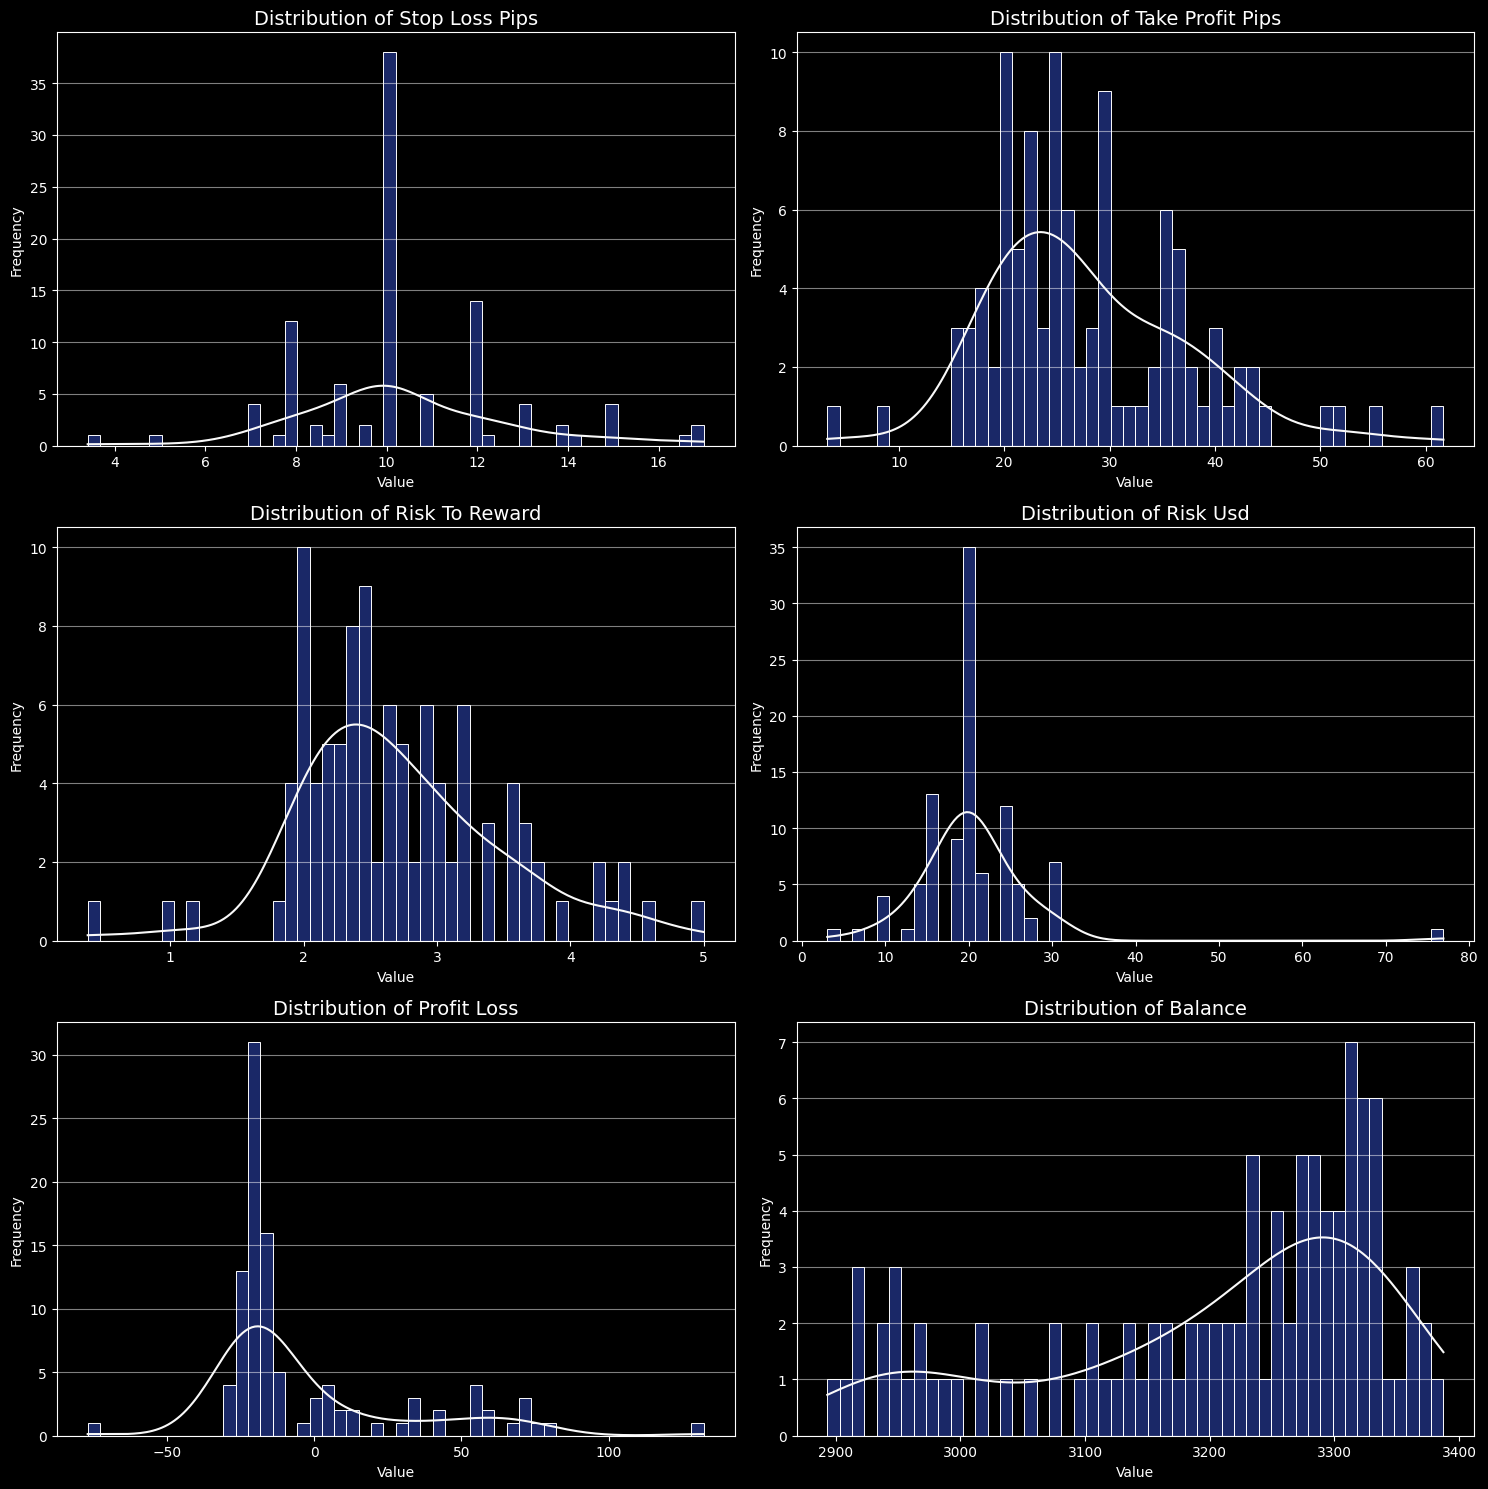

In [53]:
# Plot distributions
plot_distributions(
    numeric_columns[[column for column in numeric_columns.columns if column not in ['Duration']]]
)

In [60]:
# Boxplot Function
def plot_boxplot(data: pd.Series) -> None:
    """
    Plots a boxplot for a numeric feature in a Series.

    This function generates a boxplot to visualize the distribution and potential
    outliers for a Series.

    Args:
        data (pd.Series): The input data.

    Raises:
        TypeError: If the input data is not a pandas Series.
    """
    if not isinstance(data, pd.Series):
        raise TypeError("Input data must be a pandas Series.")
    
    # Set up the subplots
    plt.style.use('dark_background')

    plt.figure(figsize=(10, 5))
    sns.boxplot(x=data, color=palette['loss'])
    plt.title(f'Boxplot of {data.name.replace("_", " ").title()}', fontsize=14)
    plt.xlabel('Value')
    plt.grid(axis='x', alpha=0.5)
    plt.tight_layout()
    plt.show()

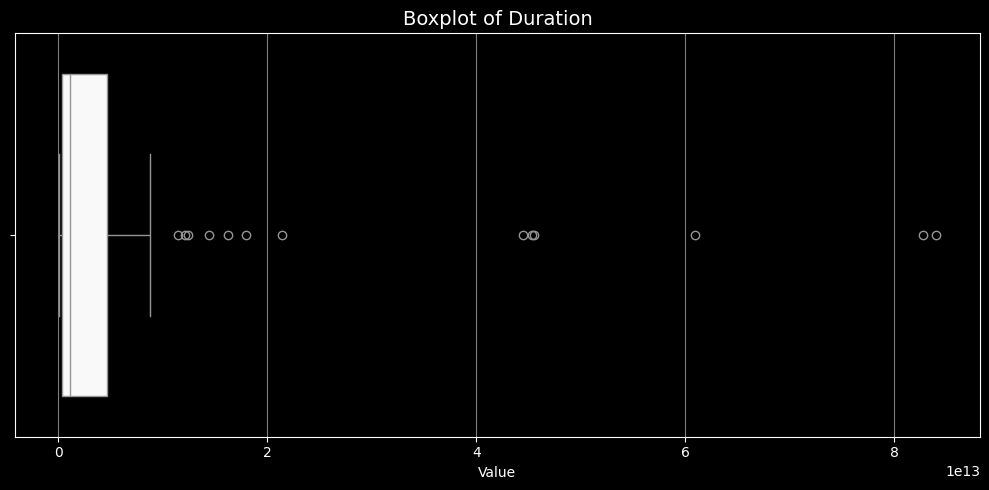

In [61]:
# Plot Distribution of Duration
plot_boxplot(numeric_columns['Duration'])

**Summary Statistics of Numeric Data**

In [83]:
# Descriptive statistics for numeric features
numeric_columns.describe()

,Stop_loss_pips,Take_profit_pips,Risk_to_reward,Risk_usd,Profit_loss,Balance,Duration
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102
mean,10.375490,27.979412,2.715285,20.526765,-2.486373,3200.180000,0 days 01:43:24.205882352
std,2.330956,9.677680,0.763636,7.594219,33.196026,137.746137,0 days 04:07:04.642804598
min,3.400000,3.200000,0.380952,3.060000,-76.900000,2893.270000,0 days 00:00:29
25%,9.000000,21.000000,2.223212,18.000000,-20.000000,3117.350000,0 days 00:06:27.750000
50%,10.000000,26.000000,2.591665,20.000000,-18.000000,3244.350000,0 days 00:19:02.500000
75%,12.000000,35.000000,3.156252,24.000000,5.940000,3309.350000,0 days 01:16:42.750000
max,17.000000,61.700000,5.000000,76.900000,132.300000,3387.350000,0 days 23:20:00


**Inferences On Numeric Columns Over the past year**  

Over the one year period 102 trades were taken.  
The trading style the strategy was based on is Intraday.


_Stop_loss_pips_
- Stop loss appears to have a normal distribution peaked at 10 pips.  
- This indicates on average, the set stop loss per trade was 10 pips away from the entry price.  
- The distribution of stop loss underpins this inference, as it peaks around the average.   
- A standard deviation of 2 pips signifies stop loss value was consistent across trades, and indicates a rigid risk management strategy was followed.  

_take_profit_pips_
- The average take profit in pips aimed for per trade was 28 pips, nearly three times the stop loss value in pips.  
- A standard deviation of 10 pips for take profits indicate the strategy allowed for flexible profit taking, rather than a set-and-forget approach.  
- A relatively larger standard deviation for take profits reflects the adaptive way, trades were allowed to run to profit targets based on different market conditions.  
- The right-skewed distribution underpins this inference, as its distribution shows a few but large take profits going up to 60 pips.  


_Risk_to_reward_
- The right-skewed distribution is peaked around 3 indicating that on average, for every risk a reward of nearly 3 times as much as the risk was aimed for.  
- A positive risk to reward is a critical component of a positive expected value.  
- A standard deviation of 0.76 reveals consistency in aiming for a high risk to reward to make more than the risk in case the trade had won.  

_Risk_usd_
- This distribution is also right-skewed and is peaked around $20.00, while a smaller number of trades involve significantly higher risk amounts over $70.00  
- This means average position size risked per trade was about $20.00. With a capital (on a demo account) of $3,141.7, this was 0.6% of the position size risked per trade.  
- A standard deviation of 7.6 indicates there was some significant variability in the amount risked per trade, underpinned by the distribution above. This indicates position sizes were adjusted to setup quality and market conditions.

_Profit_loss_
- The distibution is right-skewed and peaks around -2.5.  
- This means on average a net loss of $2.5 was taken per trade.  
- A standard deviation of $33 is exceptionally high compared to the mean Profit/Loss, indicating the trades had a wide range of outcomes. This can be attributed to a few very large impact trades as evident from the distribution.  
- The relatively significant difference between average and standard deviation shows Profit/Loss exhibits overdispersion, highlighting the impact of outliers.  

_Balance_
- It shows a left-skewed distribution which indicates even though the peak is around $3,300.00, a few drawdowns pulled the average balance down   
- With a starting capital of $3,141.70 an average balance of $3,200.00 indicates an overall positive trend of balance.  
- A standard deviation of $137.7 suggests a low-risk trading approach.  
- With a positive mean and relatively smaller standard deviation, this signifies a stable and consistently applied trading strategy.   

_Duration_
- On average each trade lasted  01:43:00. This underpins the strategy's intraday trading style, as it was intended.    
- With a standard deviation of  04:07:00, the duration for trades widely vary. This points to the duration being skewed.  
- Therefore while some trades lasted less than 2 hours, some took many hours to complete pointing out the existence of outliers in the duration of trades and exhibition of overdispersion.
- This is visualized in the boxplot for Duration.

- Upon careful observation, the strategy yielded an average positive balance but a negative average trade outcome.  
- This can be due to the account experiencing some large infrequent wins that boosted balance, even though majority of trades resulted in small losses.  
- This suggests the strategy has a low win rate, but a high risk to reward. 

**Overdispersed Features**  
For a more accurate presentation of the inferences, the median and inter-quartile range (iqr) for the features that exhibit overdispersion will be used as the measure of central tendency and dispersion respectively.  
These measures are robust to skewness in the data, and provide a clearer picture.

In [84]:
# Function to calculate IQR and outlier thresholds
def calculate_iqr_extremes(data: pd.Series) -> tuple[float, tuple[float, float]]:
    """
    Calculates the Interquartile Range (IQR) and the thresholds for mild and extreme outliers.

    Args:
        data (pd.Series): The input data as a pandas Series. The Series must
                          be of a numeric data type.

    Returns:
        tuple[float, tuple[float, float]]: A tuple containing:
                                            - The calculated IQR (Q3 - Q1).
                                            - A tuple of the extreme outlier thresholds (1.5 * IQR, 3.0 * IQR).

    Raises:
        TypeError: If the input data is not a pandas Series.
        ValueError: If the Series is empty or does not contain numeric data.
    """
    # Check for correct input type and data
    if not isinstance(data, pd.Series):
        raise TypeError("Input must be a pandas Series.")
    if data.empty:
        raise ValueError("Input Series cannot be empty.")

    # Calculate the quartiles and IQR
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1

    # Calculate the mild and extreme outlier thresholds
    mild_extremes = 1.5 * iqr
    extreme_extremes = 3.0 * iqr

    # 5. Return the IQR and the thresholds
    return iqr, (mild_extremes, extreme_extremes)

In [ ]:
# IQR for Profit_loss
profit_loss_iqr, _ = calculate_iqr_extremes(numeric_columns['Profit_loss'])
round(profit_loss_iqr, 2)

np.float64(25.94)

In [ ]:
# IQR for Duration
duration_iqr, _ = calculate_iqr_extremes(numeric_columns['Duration'])
duration_iqr

Timedelta('0 days 01:10:15')

_Profit_loss_
- With a median of $18.00 as net loss per trade, most trades were not profitable.   
- An inter-quartile range of $26.00 is relatively smaller than the average Profit/Loss.  
- This indicates losses were tightly managed and consistent when the median and IQR are used as measures rather than the mean and standard deviation, but in a way that generates frequent, small losses.  

_Duration_
- With a median of 00:19:00 it took 19 minutes for a trade to run, relatively shorter than a mean duration of 1 hour 43 minutes.  
- An IQR of 01:10:15 indicates duration of a trade varied within 1 hour 10 minutes for 50% of trades, much more stable than a standard deviation of 4 hours 7 minutes.

These inferences imply that the duration of trades has a short-term core, but flexible enough to occasionally hold trades for a much longer period in terms of hours.

### **4.1.2 Descriptive Statistics on Category Features**

The analysis of categorical features will be focused on visualizing how the categories in each feature contributed to a trade either resulting in a win or a loss. This will provide insight into which categorical values  that contributed positively to trading capital. 

In [93]:
# Get category columns
category_columns = dataframe.select_dtypes('object')

In [88]:
category_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Session          102 non-null    object
 1   Position         102 non-null    object
 2   Bias             102 non-null    object
 3   Profile          102 non-null    object
 4   Entry            102 non-null    object
 5   Confirmation     102 non-null    object
 6   Fvg_level        51 non-null     object
 7   Trail_stop       102 non-null    object
 8   Outcome          102 non-null    object
 9   Duration_binned  102 non-null    object
 10  Time_window      102 non-null    object
 11  Day              102 non-null    object
 12  Month            102 non-null    object
dtypes: object(13)
memory usage: 10.5+ KB


In [518]:
# Function to plot categorical columns against Outcome
def plot_barchart(data: pd.DataFrame, hue='Outcome') -> None:
    """
    Plots the distribution of each categorical feature in a DataFrame against the target using bar chart.

    This function takes a dataframe containg category features and generates a
    grid of subplots, using bar charts.

    Args:
        data (pd.DataFrame): The input DataFrame.
        hue (str): The target column to plot against. Default is 'Outcome'.

    Raises:
        TypeError: If the input data is not a pandas DataFrame.
        ValueError: If the DataFrame does not contain any categorical columns.
    """
    # Data Validation: Ensure the input is a DataFrame
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input data must be a pandas DataFrame.")

    # Data Validation: Check if there are any categorical columns to plot
    if data.empty:
        raise ValueError("The DataFrame does not contain any categorical columns to plot.")

    # Set up the subplots
    plt.style.use('dark_background')

    number_of_columns = len(data.columns)
    n_cols = 2
    n_rows = int(np.ceil(number_of_columns / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    
    # Flatten the axes array for easy iteration if n_rows > 1
    axes = axes.flatten()

    # Loop through category columns and plot bar charts
    for i, column in enumerate(data):
        ax = axes[i]
        
        # Plotting the bar chart on the current subplot
        sns.countplot(data=data, x=column, hue=hue, ax=ax, palette=palette)
        
        # Set titles and labels for the subplot
        ax.set_title(f'Distribution of {column.replace("_", " ").title()} on Outcome', fontsize=14)
        ax.set_xlabel(f'{column}')
        ax.set_ylabel('count')
        ax.grid(axis='y', alpha=0.2)

    # Hide any unused subplots
    for j in range(number_of_columns, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

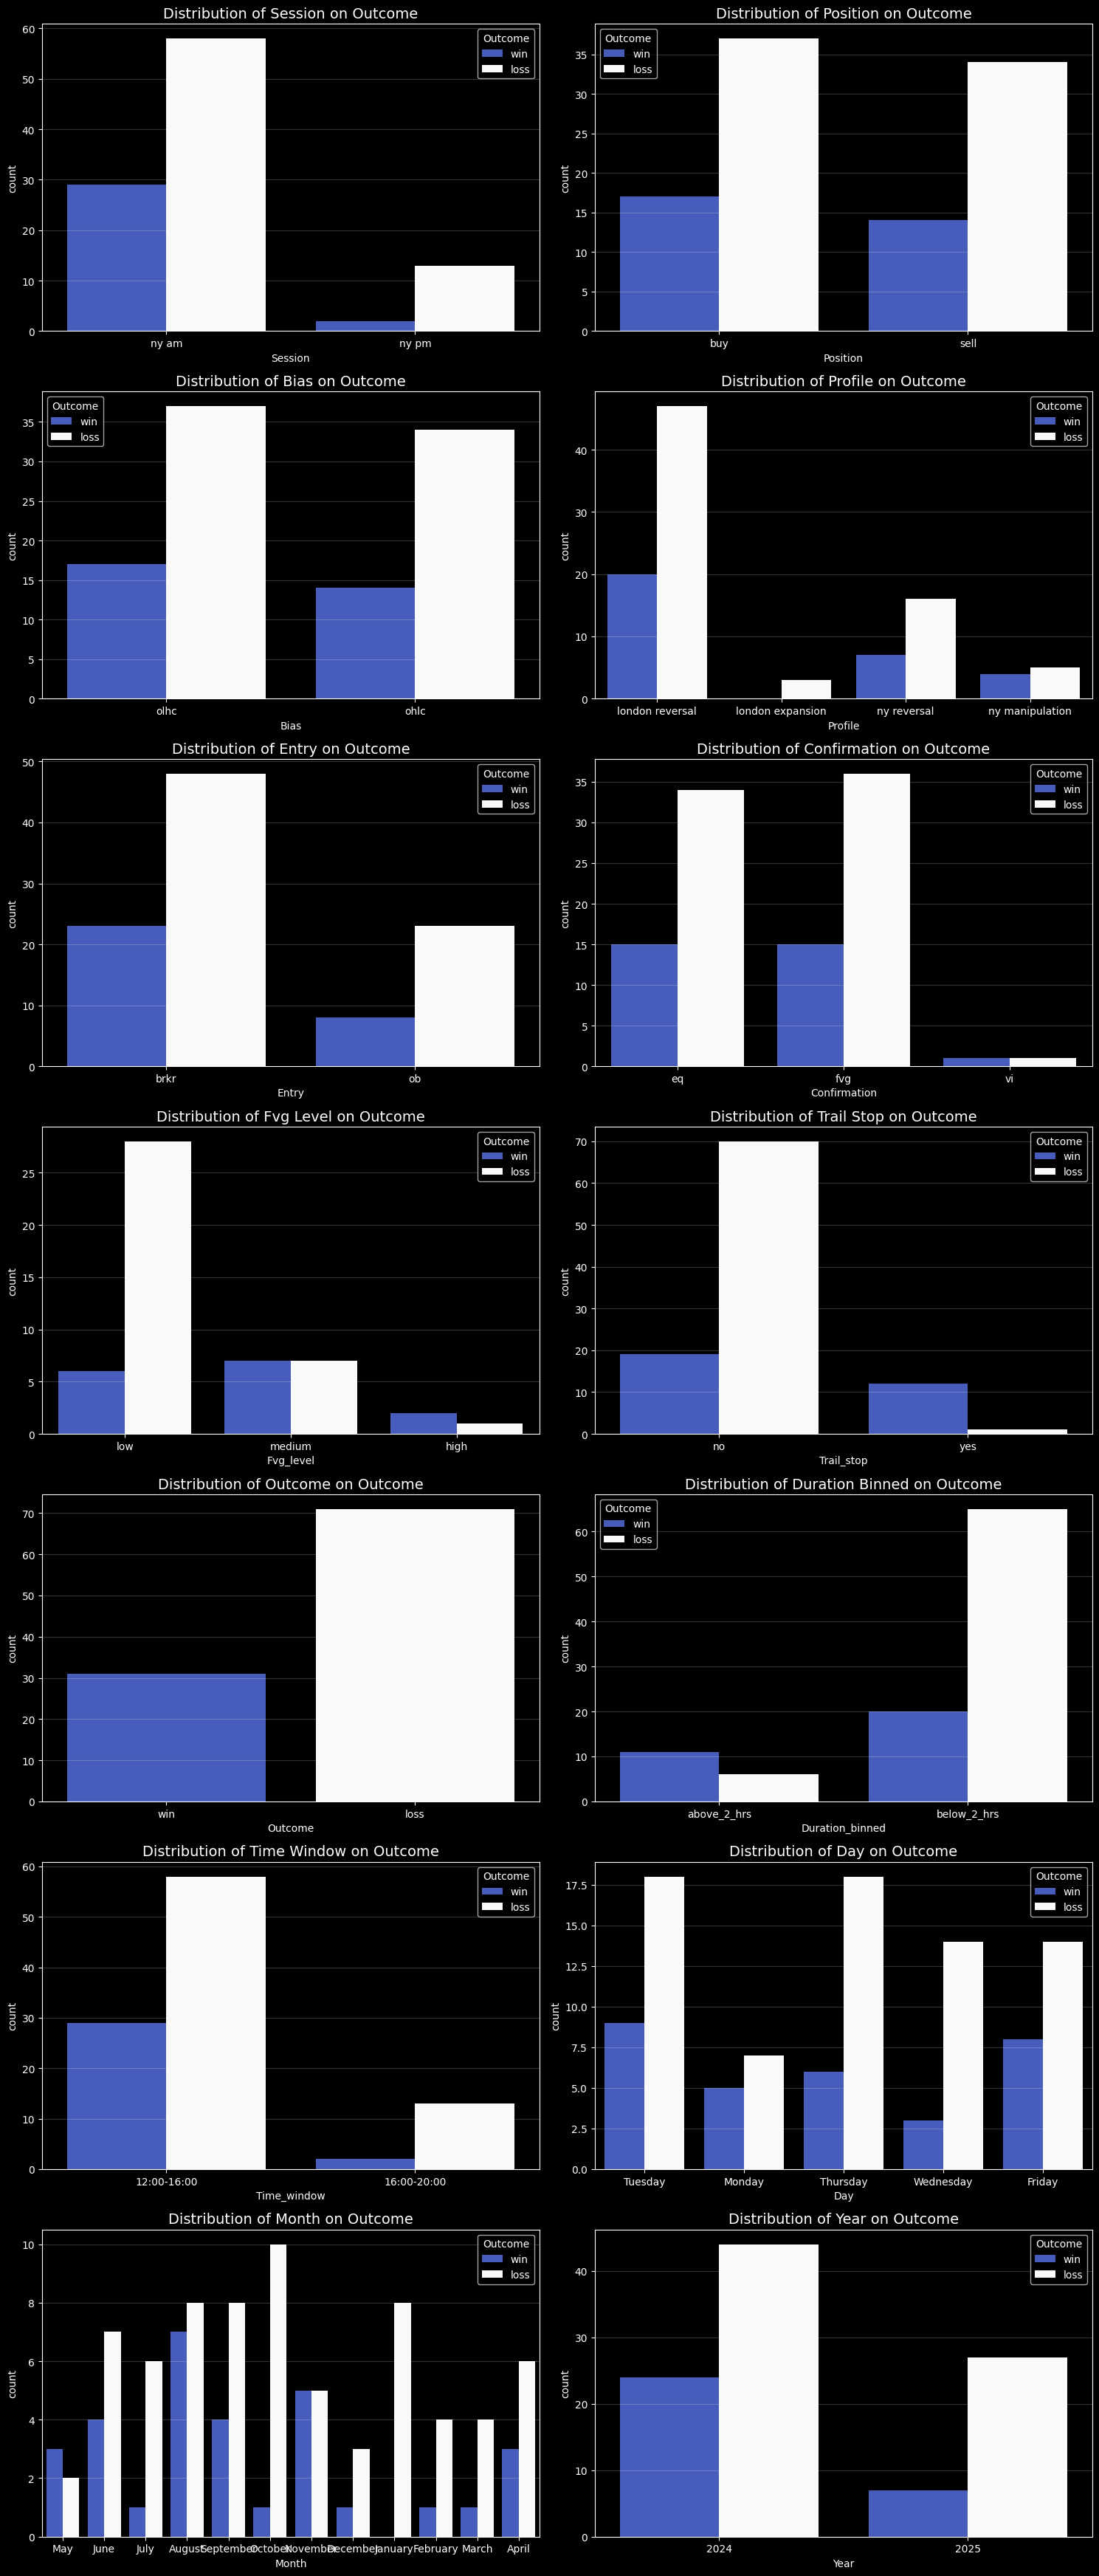

In [126]:
# Plot categorical columns against Outcome
plot_barchart(category_columns)

**Inferences On Category Features Over the past year**   

From the plots it can be concluded that generally there were more trades that resulted in a loss, than there were winning trades.

_Session_   
The New York a.m (ny am) Session appears to be the most active trading period, driving both the highest number of wins and losses. This suggests it is a high-volume, high-volatility environment for the strategy.  
The New York a.m (ny am) Session also resulted in more wins than New York p.m Session (ny pm), even relatively more often when compared to losses.  

_Position_ & _Bias_  
There is no significant statistical difference in outcomes between buy and sell positions or between olhc(bullish) and ohlc(bearish) biases. This indicates the strategy's performance is not directionally dependent.  

_Profile_  
All the profiles appear to have more trades that resulted in losses than trades resulting in wins.
London reversal was the most traded profile and accounted for the highest number of both wins and losses.  
London expansion results in no wins, but a few losses. This suggests it is a rarely used profile that seems to struggle with profitability.  
New York(ny) reversal is the next profile that resulted in losses as well as trades wins.  
New York(ny) manipulation resulted in the least amount of winning and losing trades.  

_Entry_  
Breaker Block(brkr) resulted in a higher number of trades overall, leading to more losses as well as more wins than Order Block(ob).  

_Confirmation_  
While fair value gap(fvg) and equilibrium(eq) showed similar win-loss ratio, volume imbalance(vi) resulted in the least amount of wins and losses, and yielded a balanced win-loss count.   

_Fvg_level_  
Low fvg level associated with the highest number of losses.  
Medium fvg level was more effective, with a better win-loss ratio than the low level.  
High fvg level was the most effective FVG level, yielding a higher win rate despite having the lowest trade count.  

_Trail_stop_  
Trades with a trail stop had a more favorable win-loss ratio, resulting in more winning trades than losing ones.  
Trades without a trail stop led to significantly more losses than wins.  

_Duration(Binned)_  
Trades lasting less than two hours had more wins but multiplicatively more losses than those that lasted more than two hours.  
Trades that lasted more than two hours had a positive win-loss ratio.  

_Time Window_  
Trades that were entered between 12:00 and 16:00 UTC resulted in more wins, and losses than those between 16:00 and 19:00, but has a negative win-loss ratio.  
The 16:00-19:00 range also appears to have a negative win-loss ratio but performs less on winning trades.  

_Day_  
Tuesday and Friday were the most successful days, generating the highest number of wins.  
Thursday had a relatively lower win count, but just as much loss count as Tuesday. 
Wednesday was the least successful, with the lowest win count and a high loss count.  
Monday had the fewest losses overall, suggesting a less volatile trading environment.   

_Month_  
August and November were the most profitable months, with the highest number of winning trades.  
October and January were the worst-performing months, resulting in the highest loss counts.  

_Year_  
More trades were won and lost in 2024 than in 2025.  
While both years have a negative win-loss ratio, the year 2024 has a more negative win-loss ratio than 2025.

**Findings**  

The strategy has proven to have a statistically strong core, even with its high frequency of losses. The key to improving profitability lies in isolating and amplifying the conditions under which trades are most successful. The data points to these key conclusions:

- The strong positive correlation between using a trail stop and achieving a favorable win-loss ratio is a good signal.

- Trade frequency did not translate to profitability.  
- The high win rates associated with Medium FVG Level and the balanced win-loss ratio of Volume Imbalance suggest that these are high-quality setups that can be considered in trading more frequently.  
- The days; Tuesday and Friday, and months; August and November consistently showed a better win-loss ratio.  
- Conversely, trading activities in October, January, and on Wednesdays significantly incurred losses.

### **4.1.3 Key Metrics**  
These metrics are specifically chosen to quantify and track the performance of the trading strategy over the past year. They will provide a high-level perspective and will be used for strategic decision making to refine the strategy in order to generate more wins, while mitigating losses. The metrics will be categorized into Profitability and Reliability.   

**a.) Profitability Metrics**  

These metrics bulleted below measure how much money was made or lost over the one year period.

- **average win size** & **average loss size**   
Average win size is the average profit per winning trade.  
Average loss size is how much the strategy lost per losing trade.  

_Formula_  
Average win size = gross_profit / number of win trades  
Average loss size = gross_loss / number of loss trades

In [4]:
# Function to compute average win size & average loss size
def compute_average_sizes(data: pd.Series) -> pd.DataFrame:
    """
    Computes the average win size and average loss size.

    Args:
        data (pd.Series): The input Series.

    Returns:
        pd.DataFrame: A DataFrame with the average win and loss sizes.

    Raises:
        TypeError: If input data is not a DataFrame.
        ValueError: If the specified column does not exist.
    """
    # Data Validation
    if not isinstance(data, pd.Series):
        raise TypeError("Input 'data' must be a pandas Series.")
    if data.empty:
        raise ValueError("Input Series cannot be empty.")
    
    # Retrieve wins and losses
    win_trades = data[data > 0]
    loss_trades = data[data < 0]

    # Compute Averages
    gross_profit = win_trades.sum()
    win_count = len(win_trades)
    
    gross_loss = loss_trades.sum()
    loss_count = len(loss_trades)
    
    # Calculate average win and loss sizes
    avg_win_size = round(gross_profit / win_count, 2) if win_count > 0 else 0.0
    avg_loss_size = round(abs(gross_loss) / loss_count, 2) if loss_count > 0 else 0.0
    
    # Create and return the output DataFrame
    return pd.DataFrame([{
        'avg_win_size': avg_win_size,
        'avg_loss_size': avg_loss_size
    }])

In [192]:
average_sizes = compute_average_sizes(dataframe['Profit_loss'])
average_sizes

,avg_win_size,avg_loss_size
0,40.41,20.65


In [5]:
# Function for plotting diverging bar metrics
def plot_diverging_bar(metrics: pd.DataFrame) -> None:
    """
    Plots a horizontal diverging bar chart for average win and loss metrics, 
    with refined aesthetic controls.

    The chart is centered on zero, showing wins positively and losses negatively,
    allowing for a direct visual comparison of the reward-to-risk ratio.

    Args:
        metrics_df (pd.DataFrame): A 1x2 DataFrame containing 'avg_win_size'
                                   and 'avg_loss_size' columns, where the values
                                   are in the first row.

    Raises:
        TypeError: If the input is not a pandas DataFrame.
        ValueError: If the DataFrame does not have the expected columns or dimensions.
    """
    # --- Data Validation ---
    if not isinstance(metrics, pd.DataFrame):
        raise TypeError("Input data must be a pandas DataFrame.")
    
    required_cols = ['avg_win_size', 'avg_loss_size']
    if not all(col in metrics.columns for col in required_cols):
        raise ValueError(
            f"DataFrame must contain columns: {required_cols}. Found: {metrics.columns.tolist()}"
        )
    if metrics.shape[0] != 1:
        raise ValueError("DataFrame must be 1x2 dimension, containing metrics in the first row.")

    # --- Data Restructuring and Palette ---
    
    # Define the palette and metrics
    win_size = metrics['avg_win_size'].iloc[0]
    # Loss size is negated for plotting on the negative side of the x-axis
    loss_size = -metrics['avg_loss_size'].iloc[0] # This will be -20.65

    # Create a new DataFrame optimized for the diverging plot
    plot_data = pd.DataFrame({
        'Metric': ['Average Win Size', 'Average Loss Size'],
        'Value': [win_size, loss_size],
        'Color': [palette['win'], palette['loss']]
    })
    
    # Sort for consistent plotting order (Win above Loss)
    plot_data.sort_values('Value', ascending=False, inplace=True)
    plot_data.reset_index(drop=True, inplace=True)
    
    # --- Plotting ---
    
    plt.figure(figsize=(10, 5), dpi=100)
    
    # Plotting the horizontal bars with increased linewidth (thickness)
    plt.hlines(
        y=plot_data.index, # Use the numeric index for plotting
        xmin=0, 
        xmax=plot_data['Value'],
        color=plot_data['Color'], 
        alpha=1, 
        linewidth=35 # 1. Adjustment: Increased thickness for wider bars
    )
    
    # Decorations
    
    # 2. Adjustment: Set tight Y-axis limits to bring bars closer to the center
    plt.ylim(-0.5, 1.5)
    
    # 3. Adjustment: Set wider X-axis limits (1.55 multiplier) to fit text labels
    # Use the absolute maximum value for symmetrical limits
    max_abs_val = max(abs(win_size), abs(loss_size))
    plt.gca().set(
        ylabel='', 
        xlabel='Average Value (Pips/Currency)',
        xlim=(-max_abs_val * 1.55, max_abs_val * 1.55) 
    )
    
    # Set y-axis labels to the metric names
    plt.yticks(plot_data.index, plot_data['Metric'])
    
    plt.title(
        'Reward vs. Risk: Average Trade Size Comparison', 
        fontdict={'size': 16}
    )
    
    # Add labels for the exact values (fixed to pop inside the plot)
    for i, row in plot_data.iterrows():
        # Text offset slightly more conservative than the axis limit (1.05)
        xtext = row['Value'] * 1.05
        ha = 'left' if row['Value'] > 0 else 'right'
        
        # Color the text to contrast with the dark background
        text_color = 'white' if row['Color'] == '#f9f9f9' else 'black'
        
        plt.text(xtext, i, f'{abs(row["Value"]):.2f}', 
                 horizontalalignment=ha, 
                 color='white', # Use white text for visibility against the plot background
                 fontsize=12)

    plt.axvline(0, color='gray', linestyle='--', alpha=0.5) # Center line at zero
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

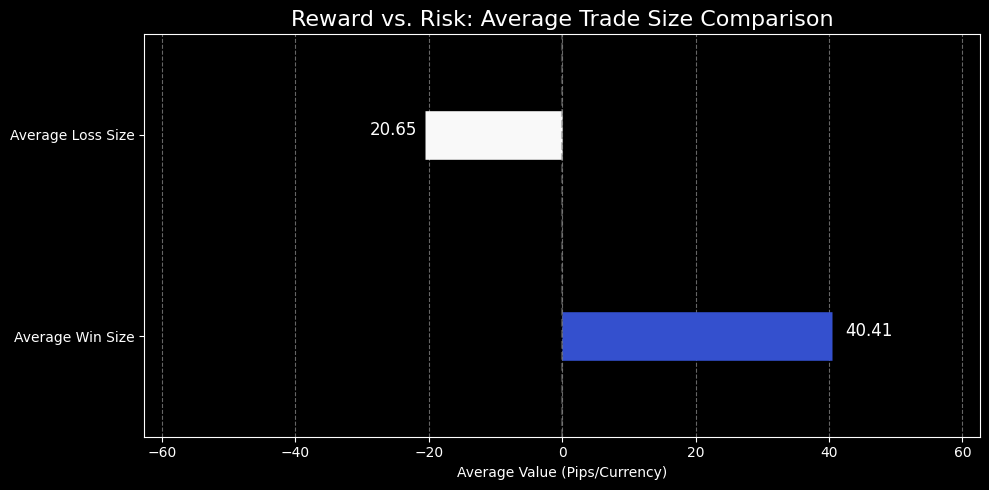

In [75]:
plot_diverging_bar(average_sizes)

In [76]:
dataframe.to_csv('check_point_3.csv', index=False)

dataframe = pd.read_csv('check_point_3.csv')

It is evident from the divergent bar chart that, over the one year trading period;  

The strategy generated a win size of $40.41, and lost $20.65 on average.   
This inference underpins the fact that the strategy has smaller loss size which may provides a strong buffer against drawdowns.

- **Net Profit**  
Total profit from all trades whether they resulted in wins or losses.  

_Formula_  
Net Profit = Gross Profit - Gross Loss  

Gross Profit: total profit from all winning trades.  
Gross Loss: total loss from all lossing trades. 

In [6]:
# Function to generate gross_profit, gross_loss & net_profit
def compute_profitability(data: pd.Series) -> pd.DataFrame:
    """
    Computes gross profit, gross loss, and net profit from the trading data.

    This function accurately calculates profitability metrics for specific 
    outcomes (e.g., 'win' and 'loss') and returns them in a DataFrame.

    Args:
        data (pd.DataFrame): The input DataFrame.
        filter_column (str): The column used to filter outcomes (e.g., 'Outcome').
        filter_values (List[str]): A list of two strings to filter by, where
                                    the first is the 'win' value and the second
                                    is the 'loss' value.
        target_column (str): The column containing the profit/loss values.

    Returns:
        pd.DataFrame: A DataFrame with gross_profit, gross_loss, and net_profit.

    Raises:
        TypeError: If input data is not a DataFrame or filter_values is not a list.
        ValueError: If specified columns do not exist or filter_values is not of length 2.
    """
    # Data Validation
    if not isinstance(data, pd.Series):
        raise TypeError("Input 'data' must be a pandas Series.")
    if data.empty:
        raise ValueError("Input Series cannot be empty.")
    
    # Retrieve wins and losses
    win_data = data[data > 0]
    loss_data = data[data < 0]

    # Gross profit
    gross_profit = win_data.sum()

    # Gross loss
    gross_loss = loss_data.sum()

    # Net profit
    net_profit = gross_profit - abs(loss_data.sum())

    # Create and return dataframe for metrics
    return pd.DataFrame([{'gross_profit': gross_profit,
                        'gross_loss': gross_loss,
                        'net_profit': net_profit}])

In [80]:
profitability = compute_profitability(data=dataframe['Profit_loss'])
profitability

,gross_profit,gross_loss,net_profit
0,1212.36,-1465.97,-253.61


In [522]:
# Function to plot waterfall plot
def plot_waterfall(metrics: pd.DataFrame) -> None:
    """
    Plots a waterfall chart illustrating the flow from Gross Profit and Gross Loss 
    to the final Net Profit (Balance).

    The chart clearly shows how the negative metric (Gross Loss) offsets the 
    positive metric (Gross Profit) to result in the final Net Profit.

    Args:
        metrics_df (pd.DataFrame): A 1x3 DataFrame containing 'gross_profit', 
                                   'gross_loss', and 'net_profit' columns, 
                                   with the values in the first row.

    Raises:
        TypeError: If the input is not a pandas DataFrame.
        ValueError: If the DataFrame does not have the expected columns or dimensions.
    """
    # --- Data Validation ---
    if not isinstance(metrics, pd.DataFrame):
        raise TypeError("Input data must be a pandas DataFrame.")
    
    required_cols = ['gross_profit', 'gross_loss', 'net_profit']
    if not all(col in metrics.columns for col in required_cols):
        raise ValueError(
            f"DataFrame must contain columns: {required_cols}. Found: {metrics.columns.tolist()}"
        )
    if metrics.shape[0] != 1:
        raise ValueError("DataFrame must contain metrics in exactly one row.")

    
    # Extract values 
    gross_profit = metrics['gross_profit'].iloc[0]
    gross_loss = metrics['gross_loss'].iloc[0]
    net_profit = metrics['net_profit'].iloc[0]
    
    # Categories for the x-axis
    categories = ['Gross Profit', 'Gross Loss', 'Net Profit']
    
    # Relative values for the steps:
    # 1. Gross Profit (starts from 0)
    # 2. Gross Loss (is the negative step)
    # 3. Net Profit (final bar - calculated implicitly)
    values = [gross_profit, gross_loss] 
    
    # Calculate the cumulative sum (required for the 'bottom' argument in ax.bar)
    cumulative_values = np.cumsum(values)
    
    # --- Plotting ---
    
    plt.figure(figsize=(8, 6), dpi=100, facecolor='#202020')
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

    # 1. Plot Gross Profit (Positive step)
    ax.bar(
        categories[0], 
        values[0], 
        bottom=0,
        color=palette['win']
    )
    
    # 2. Plot Gross Loss (Negative step)
    # The 'bottom' starts from Gross Profit's level (cumulative_values[0])
    ax.bar(
        categories[1],
        values[1],
        bottom=cumulative_values[0],
        color=palette['loss']
    )
    
    # 3. Plot the final Net Profit bar (Cumulative total)
    # The final bar's height is np_val (Net Profit)
    ax.bar(
        categories[2], 
        net_profit, 
        bottom=0,
        color=palette['win'] if net_profit >= 0 else palette['loss']
    )
    
    # Add transition lines (optional but highly recommended for waterfalls)
    # Line from Gross Profit end to Gross Loss start
    plt.plot([0, 1], [cumulative_values[0], cumulative_values[0]]) #, 'k--', color='gray', linewidth=1)
    # Line from Gross Loss end to Net Profit start
    plt.plot([1, 2], [cumulative_values[1], cumulative_values[1]]) #, 'k--', color='gray', linewidth=1)
    
    # Add labels for the values (important for clarity)
    for i, (cat, val) in enumerate(zip(categories[:2], values)):
        # Text position: 
        # For Gross Profit, place above the bar. For Gross Loss, place inside/below.
        y_pos = (cumulative_values[i] - val / 2) if val < 0 else (cumulative_values[i] + val / 2)
        ax.text(i, y_pos, f'{val:,.2f}', ha='center', va='center', fontsize=10, color='black' if val > 0 else 'white')
        
    # Net Profit label (final bar)
    ax.text(2, net_profit / 2, f'{net_profit:,.2f}', ha='center', va='center', fontsize=10, color='black' if net_profit >= 0 else 'white')


    # Add labels and title
    ax.set_title('Financial Flow: Gross Profit to Net Profit', fontsize=14)
    ax.set_ylabel('Value ($)')
    
    # Set x-axis labels
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

<Figure size 800x600 with 0 Axes>

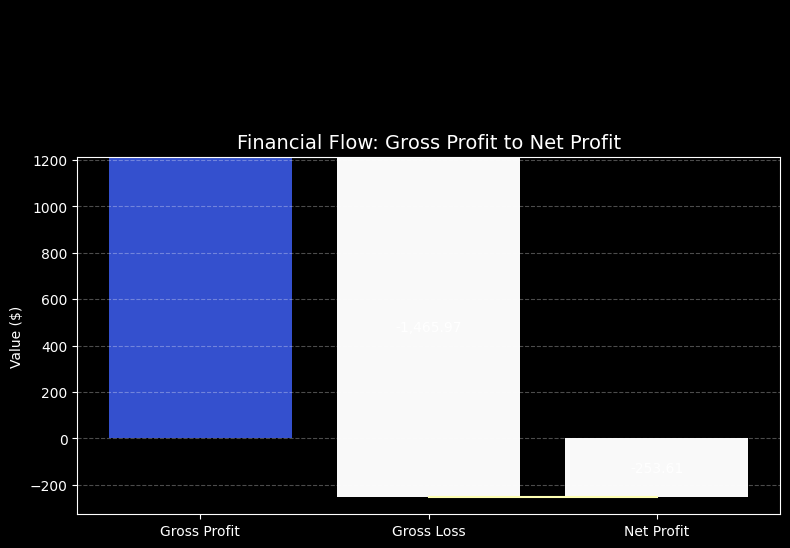

In [86]:
plot_waterfall(profitability)

Evidently from the build-up waterfall chart, over the entire one year period and taking 102 trades;   

- The strategy generated $1,212.36 overall, and lost $1,465.97 overall.  
- This resulted in a net loss of $253.61 by the end of the one year trading period

- **Expectancy**  
This is the average profit or loss expected to be made per trade over the one year period of trading.

_formula_  
Expectancy = (Win Rate * Average Win Size) - (Loss Rate * Average Loss Size)

In [7]:
# Function to compute Expectancy
def compute_expectancy(win_rate: float, avg_win_size: float, avg_loss_size: float) -> float:
    """
    Calculates the expectancy of a trading strategy.

    Expectancy is a statistical measure of the average profit or loss 
    a trader can expect to make per trade over the long run.

    Args:
        win_rate (float): The percentage of trades that are profitable,
                          expressed as a decimal (e.g., 0.40 for 40%).
        avg_win_size (float): The average profit per winning trade.
        avg_loss_size (float): The average loss per losing trade.

    Returns:
        float: The expected value, representing the average profit or loss per trade.

    Raises:
        TypeError: If any of the inputs are not numerical.
        ValueError: If win_rate is not within the range [0.0, 1.0].
    """
    # Data Validation
    if not all(isinstance(x, (int, float)) for x in [win_rate, avg_win_size, avg_loss_size]):
        raise TypeError("All input parameters must be numerical.")
    if not (0.0 <= win_rate <= 1.0):
        raise ValueError("Win rate must be a decimal between 0.0 and 1.0.")

    # Calculate the loss rate
    loss_rate = 1 - win_rate

    # Compute expected value
    expectancy = (win_rate * avg_win_size) - (loss_rate * avg_loss_size)

    return expectancy

In [193]:
expectancy = compute_expectancy(win_rate=win_rate, 
                   avg_win_size=average_sizes['avg_win_size'][0],
                   avg_loss_size=average_sizes['avg_loss_size'][0]
                   )
expectancy

np.float64(-2.331999999999999)

The strategy yielded a negative expectancy of $2.3 per trade.  
Meaning each trade statistically lost $2.3 over the one year period.   
It also points out that a win rate of 30% is not high enough to compensate for the average loss size

- **Profit Factor**  
The profit factor indicates how much profit the strategy generated for every dollar risked.  
A profit factor above 1 generally signifies a profitable strategy.  
Less than 1 indicates the strategy may struggle to cover trading expenses.  
And exactly 1 indicates break even of the strategy i.e. total wins is equal to total losses.

_formula_  
Gross Profit / Gross Loss


In [8]:
# Function to compute profit_factor
def compute_profit_factor(gross_profit: float, gross_loss: float) -> float:
    """
    Calculates the profit factor of a trading strategy.

    The profit factor is the ratio of a trading strategy's gross profit
    to its gross loss. A profit factor greater than 1.0 indicates a profitable
    strategy.

    Args:
        gross_profit (float): The total profit from all winning trades.
        gross_loss (float): The total loss from all losing trades (as a positive value).

    Returns:
        float: The profit factor, rounded to two decimal places.
               Returns 0.0 if gross loss is zero to prevent division by zero.

    Raises:
        TypeError: If inputs are not numerical.
        ValueError: If gross_loss is negative.
    """
    # Data Validation
    if not all(isinstance(x, (int, float)) for x in [gross_profit, gross_loss]):
        raise TypeError("Inputs must be numerical.")
    if gross_loss < 0:
        raise ValueError("Gross loss must be a positive value.")

    # Optimized Calculation with a check for division by zero
    if gross_loss == 0:
        return 0.0
    
    return round(gross_profit / gross_loss, 2)

In [89]:
profit_factor = compute_profit_factor(gross_profit=profitability['gross_profit'][0],
                                      gross_loss=profitability['gross_loss'][0])
profit_factor

np.float64(0.83)

A profit factor of 0.83 concludes the trading strategy is not statistically profitable.  
This means for every dollar risked, only $0.83 was made.  
This confirms the Expectancy's value as an insightful metric of the strategy's performance.

- **Equity curve**  
This tracks the change in the value of trading capital over the one year period.

In [91]:
equity_data = dataframe[['Balance', 'Trade_close']]
equity_data = (
    equity_data.set_index('Trade_close')
               .resample('ME').last()
)

In [142]:
# Function to plot equity curve
def plot_equity_curve(
    data: pd.DataFrame, 
    x_col: str, 
    y_col: str,
    title = 'Equity Curve of BNTP Trading Strategy'
) -> None:
    """
    Plots a visually appealing and robust equity curve.

    Args:
        data (pd.DataFrame): The DataFrame containing the trading data.
        x_col (str): The name of the column for the x-axis (e.g., 'trade_close').
        y_col (str): The name of the column for the y-axis (e.g., 'Balance').
        title (str, optional): The title for the plot. Defaults to 'BNTP Equity Curve'.

    Raises:
        TypeError: If the input is not a DataFrame.
        ValueError: If the specified columns do not exist in the DataFrame.
    """
    # Data Validation
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input 'data' must be a pandas DataFrame.")
    if x_col not in data.columns or y_col not in data.columns:
        raise ValueError("Specified x_col or y_col do not exist in the DataFrame.")
    
    # Set up the subplots
    plt.style.use('dark_background')
        
    # Calculate the running maximum balance for drawdown and annotation
    data['running_max'] = data[y_col].cummax()
    
    # Set plot style and figure size
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot the line for the equity curve
    sns.lineplot(
        data=data,
        x=x_col,
        y=y_col,
        ax=ax,
        color=palette['loss'], 
        linewidth=1.5,
        label='Balance'
    )
    
    # Create gradient fill under line plot
    ax.fill_between(
        x=data[x_col],
        y1=data[y_col],
        y2=data[y_col].min(),
        color=palette['win'],
        alpha=0.7
    )

    # Plot Customization
    ax.set_title(title, fontsize=20, pad=20)
    ax.set_xlabel(f'{x_col.replace("_", " ").title()}', fontsize=20)
    ax.set_ylabel(f'{y_col.title()}', fontsize=12)
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    ax.grid(axis='x', linestyle='--', alpha=0.09)
    ax.grid(axis='y', linestyle='--', alpha=0.09)
    
    # Use Matplotlib's DateFormatter to clean up the x-axis labels
    if pd.api.types.is_datetime64_any_dtype(data[x_col]):
        plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

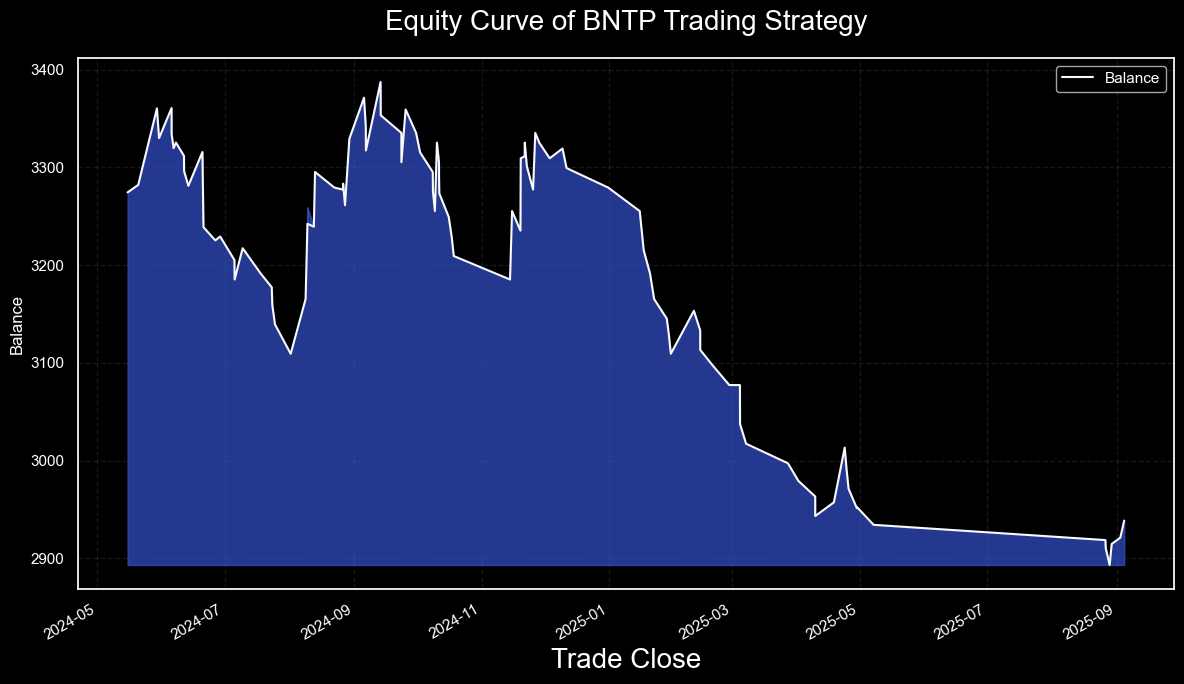

In [143]:
plot_equity_curve(dataframe, 'Trade_close', 'Balance')

It appears trading balance peaked at three major occassions; initially when trading began, in October of 2024 which was when the strategy yielded the most profit, and by the end of 2024.  
Five months into 2025 the balance eroded drastically to an all time low, right before a minor peak was attained in May.  
Balance steadily declined through the rest of the active trading months in 2025.

**b.) Reliability Metrics**  
These metrics bulleted below measure the consistency of the strategy and the performance of risk management.  

- **Win Rate**  
This computes the percentage of winning trades.  

Formula:  
(win Trades / Total trades taken)

In [87]:
# Function to compute win rate
def compute_win_rate(data: pd.Series) -> float:
    """
    Calculates the win rate from a Series of trade outcomes.

    Args:
        outcomes (pd.Series): A pandas Series containing trade outcomes,
                              where 'win' and 'loss' are common values.
                            

    Returns:
        float: The win rate, rounded to two decimal places.

    Raises:
        TypeError: If the input is not a pandas Series.
        ValueError: If the Series is empty.
    """
    # Data Validation
    if not isinstance(data, pd.Series):
        raise TypeError("Input must be a pandas Series.")
    if data.empty:
        raise ValueError("The input Series cannot be empty.")
    
    # Count wins
    win_count = (data == 'win').sum()
    total_trades = len(data)
    
    # Avoid division by zero
    if total_trades == 0:
        return 0.0

    return round(win_count / total_trades, 2)

In [88]:
win_rate = compute_win_rate(dataframe['Outcome'])
win_rate

np.float64(0.3)

In [96]:
# Function to plot a gauge chart
def plot_gauge_chart(metric: float, metric_name: str) -> None:
    # Set of colors for chart segments
    # Predefined color palette for plots
    colors = ["#0f278f", "#233db4", "#3253e9", "#4b6bfd", "#5c75e7", "#95a9ff", "#d0d8fd"]
    #colors = ['#4dab6d', '#72c66e', '#c1da64', '#f6ee54', '#fabd57', '#f36d54', '#ee4d55'] 

    #Define boundaries
    boundary_values = [100, 80, 60, 40, 20, 0, -20, -40]
    x_axis_values = [0, .44, .88, 1.32, 1.76, 2.2, 2.64]
    boundary_locations = [0, .44, .88, 1.32, 1.76, 2.2, 2.64, 3.18]

    # Set the plot background
    plt.style.use('dark_background')

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='polar')

    ax.bar(x=x_axis_values, width=.5, height=.5, bottom=2, 
            color=colors, linewidth=3, edgecolor='white', 
            align='edge')

    x_axis_values.append(3.18)
    for loc, value in zip(boundary_locations, boundary_values):
        plt.annotate(value, xy=(loc, 2.5),
                    ha='right' if value<=20 else 'left')

    plt.annotate('Outstanding', xy=(.06,2.), rotation=-75, color='white', fontweight='bold', fontsize=13)
    plt.annotate('Excellent', xy=(.63,1.87), rotation=-55, color='white', fontweight='bold', fontsize=13)
    plt.annotate('Good', xy=(1.15,2.1), rotation=-32, color='white', fontweight='bold', fontsize=13)
    plt.annotate('Average', xy=(1.67,2.22), rotation=0, color='white', fontweight='bold', fontsize=13)
    plt.annotate('Fair', xy=(2.07,2.22), rotation=30, color='white', fontweight='bold', fontsize=13)
    plt.annotate('Poor', xy=(2.5,2.28), rotation=48, color='white', fontweight='bold', fontsize=13)
    plt.annotate('Unacceptable', xy=(3.07,2.38), rotation=75, color='white', fontweight='bold', fontsize=13)

    # Find where the metric falls between boundary_values
    metric_scaled = round(metric*1e2)

    index = next(i for i, val in enumerate(boundary_values) if val <= metric_scaled)
    high_boundary_value = boundary_values[index-1]
    low_boundary_value =  boundary_values[index]

    high_boundary_location = boundary_locations[index-1]
    low_boundary_location = boundary_locations[index]

    # Compute proportional distance of metric within the value range
    value_range_difference = high_boundary_value - low_boundary_value
    if value_range_difference == 0:
        # Avoid division by zero of boundaries have same value
        dial_angle_rad = high_boundary_location
    else:
        proportion = (high_boundary_value - metric_scaled) / value_range_difference
        
        angle_range_difference = low_boundary_location - high_boundary_location
        dial_angle_rad = high_boundary_location + (proportion * angle_range_difference)

    # Re-align x_axis_values for cleaner loop
    temp_x_axis_values = list(x_axis_values)
    temp_x_axis_values.append(3.18) 

    metric_str = f"{metric_scaled:.1f}%"
    plt.annotate(metric_str, xytext=(0,0), xy=(dial_angle_rad, 2.),
                arrowprops=dict(arrowstyle='wedge, tail_width=.5', color='white', shrinkA=0),
                bbox=dict(boxstyle='circle', facecolor='white', linewidth=4.),
                fontsize=15, color='black',
                ha='center')

    plt.title(f'Performance Metric: {metric_name}', loc='center', pad=20,
            fontsize=27, fontweight='bold')

    ax.set_axis_off()
    
    #plt.tight_layout()
    plt.show()

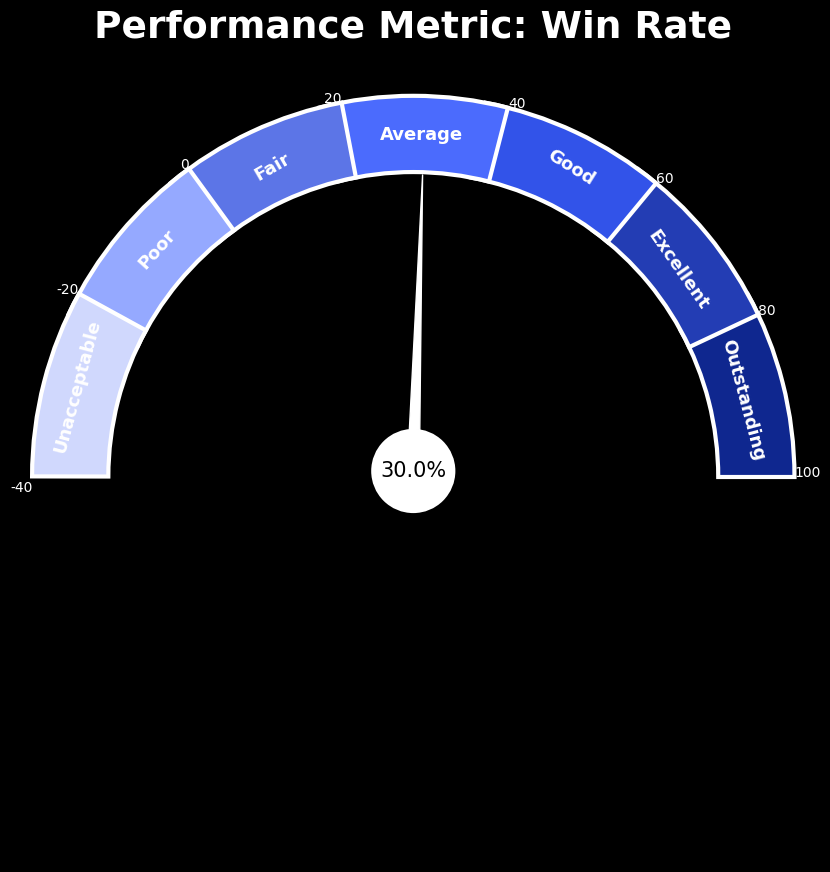

In [95]:
plot_gauge_chart(win_rate, 'Win Rate')

The strategy yielded a 30% win rate. This suggests for every three trades taken, one resulted in a win.  
This solidifies the conclusion that the strategy's profitability is dependent on it's average win size being significantly larger than its average loss size.

- **Consecutive Wins and Losses**  
How many continuous trades resulted in wins, and how many resulted in losses.  

In [11]:
# Compute longest consecutive winning and losing trades
def compute_longest_streaks(data: pd.Series) -> pd.Series:
    """
    Computes the length of the longest consecutive winning and losing streaks.

    Args:
        data (pd.Series): A pandas Series containing trade outcomes,
                          with values 'win' and 'loss'.

    Returns:
        pd.Series: A Series containing the length of the longest winning
                   and losing streaks, with 'win_streak' and 'loss_streak' as the index.

    Raises:
        TypeError: If the input is not a pandas Series.
        ValueError: If the Series contains values other than 'win' or 'loss'.
    """
    # Data Validation
    if not isinstance(data, pd.Series):
        raise TypeError("Input 'data' must be a pandas Series.")

    # Check for invalid values in the Series
    valid_outcomes = {'win', 'loss'}
    if not data.isin(valid_outcomes).all():
        raise ValueError("Series must only contain 'win' and 'loss' values.")

    # Create a boolean series to identify the wins.
    is_win = (data == 'win')
    
    # Collect winning streaks 
    streak_id = (is_win != is_win.shift()).cumsum()
    
    # Group by the unique streak ID and get the size of each streak.
    streak_summary = data.groupby(streak_id).agg(
        streak_length=('size'),
        outcome=('first')
    )

    # 3. Filter for the longest streaks
    longest_win_streak = streak_summary[streak_summary['outcome'] == 'win']['streak_length'].max()
    longest_loss_streak = streak_summary[streak_summary['outcome'] == 'loss']['streak_length'].max()
    
    # Handle cases where there are no wins or losses
    if pd.isna(longest_win_streak):
        longest_win_streak = 0
    if pd.isna(longest_loss_streak):
        longest_loss_streak = 0
    
    # 4. Return the results
    return pd.Series(
        data=[longest_win_streak, longest_loss_streak],
        index=['win_streak', 'loss_streak']
    )

In [4]:
compute_longest_streaks(dataframe['Outcome'])

win_streak      3
loss_streak    10
dtype: int64

In [5]:
win_streak = compute_longest_streaks(dataframe['Outcome'])['win_streak']
win_streak

np.int64(3)

with a win streak of 3 trades, it can be deduced that the strategy relied on low-frequency, high-impact approach.  
This asserts the fact that small losses frequently happened, and large wins occured seldomly.  
These values for win and loss treaks strongly underpins the win rate of 30%.

- **Maximum Drawdown**  
Measures the largest drop of the trading capital from its peak value to a subsequent lowest point, before a new peak was attained.  
This will determine the most severe loss of capital over the one year trading period.  
A low MDD is preferred as this indicates losses were small.  

_Formula_  
MDD = (Trough value - Peak value) / Peak Value

In [98]:
# Function for computing maximum drawdown
def compute_max_drawdown(data: pd.Series) -> float:
    """
    Computes the maximum drawdown of a balance series.

    Maximum drawdown is the largest decline from a peak to a subsequent trough.
    It is a critical measure of risk. The function returns the max drawdown
    value.

    Args:
        balance_series (pd.Series): A pandas Series containing the equity or
                                    account balance over time.

    Returns:
        float: The maximum drawdown value as a percentage.
                Returns 0 if the balance has no negative change.
    
    Raises:
        TypeError: If the input is not a pandas Series.
        ValueError: If the Series is empty.
    """
    # Data Validation
    if not isinstance(data, pd.Series):
        raise TypeError("Input must be a pandas Series.")
    if data.empty:
        raise ValueError("The input Series cannot be empty.")

    # Calculate the running maximum (the peaks)
    peak_values = data.cummax()
    
    # Calculate the drawdowns as percentages
    drawdowns = (data - peak_values) / peak_values
    
    # Return the maximum (most negative) value from the drawdowns series
    max_drawdown = drawdowns.min()
    
    # Return 0 if there are no drawdowns
    if max_drawdown > 0:
        return 0.0

    return max_drawdown

In [99]:
max_dd = compute_max_drawdown(dataframe['Balance'])
max_dd

np.float64(-0.14586033329889145)

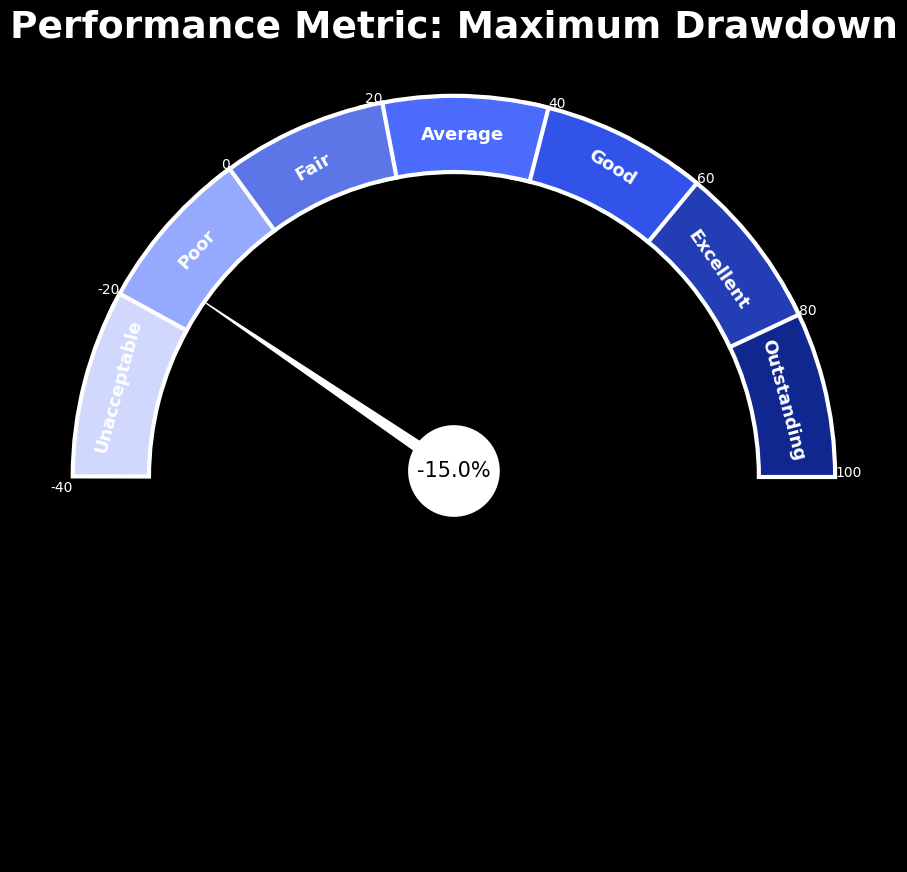

In [100]:
plot_gauge_chart(max_dd, 'Maximum Drawdown')

A drawdown of -15% indicates the strategy lost 15% of total trading capital over the one year period.  
This is a relatively big loss over one year and further underpins the fact that the strategy had a negative expectancy and a less than 1.0 profit factor.

- **Sortino Ratio**  
This metric will measure the performance of the strategy by using the standard deviation of the volatility of losses.  
Since the strategy generally resulted in a loss, the Sortino ratio is a more appropriate measure of risk since it focuses on downside risk.
Basically, it tests the quality and consistency of the profit relative to the bad outcomes.
A higher Sortino ratio indicates a more favorable risk-adjusted return for the strategy, vice versa.    

The calculation of the Sortino ratio will require the Risk Free Rate; a hypothetical profit the strategy will yield with zero risk.  
Since the strategy profits or loses on a daily basis, Risk Free Rate can be assumed to be 0.0%, to focus the Sortino Ratio purely on the downside risk on a day by day basis.  

_Formula_  
Sortino Ratio = (Average Excess Return of Strategy  −  Risk-Free Rate) / Downside Deviation

In [101]:
# Function to compute Sortino Ratio
def compute_sortino_ratio(data: pd.Series, risk_free_rate: float = 0.0) -> float:
    """
    Computes the Sortino Ratio for a series of returns.

    The Sortino Ratio is a risk-adjusted performance metric that measures
    the return of an investment relative to the downside risk. It is similar
    to the Sharpe Ratio but only considers downside volatility.

    Args:
        data (pd.Series): A pandas Series containing the returns of the investment.
        risk_free_rate (float, optional): The risk-free rate of return. Defaults to 0.0.

    Returns:
        float: The Sortino Ratio, rounded to two decimal places.
    """
    # Data Validation
    if not isinstance(data, pd.Series):
        raise TypeError("Input 'data' must be a pandas Series.")
    if data.empty:
        raise ValueError("Input Series cannot be empty.")
    if not all(isinstance(x, (int, float)) for x in data):
        raise ValueError("All elements in the Series must be numerical.")

    # Average Excess return above the risk-free rate
    average_return = np.mean(data.values) - risk_free_rate

    # Identify returns below the risk-free rate
    downside_return = data[data < risk_free_rate].values
    
    # Downside deviation
    downside_deviation = np.sqrt(np.mean((risk_free_rate - downside_return)**2))
    
    # Avoid division by zero
    if downside_deviation == 0:
        return np.inf if average_return > 0 else 0.0
    
    return round(average_return / downside_deviation, 2)
    

In [102]:
# Calculate Sortino Ratio
sortino_ratio = compute_sortino_ratio(dataframe['Profit_loss'])
sortino_ratio

np.float64(-0.11)

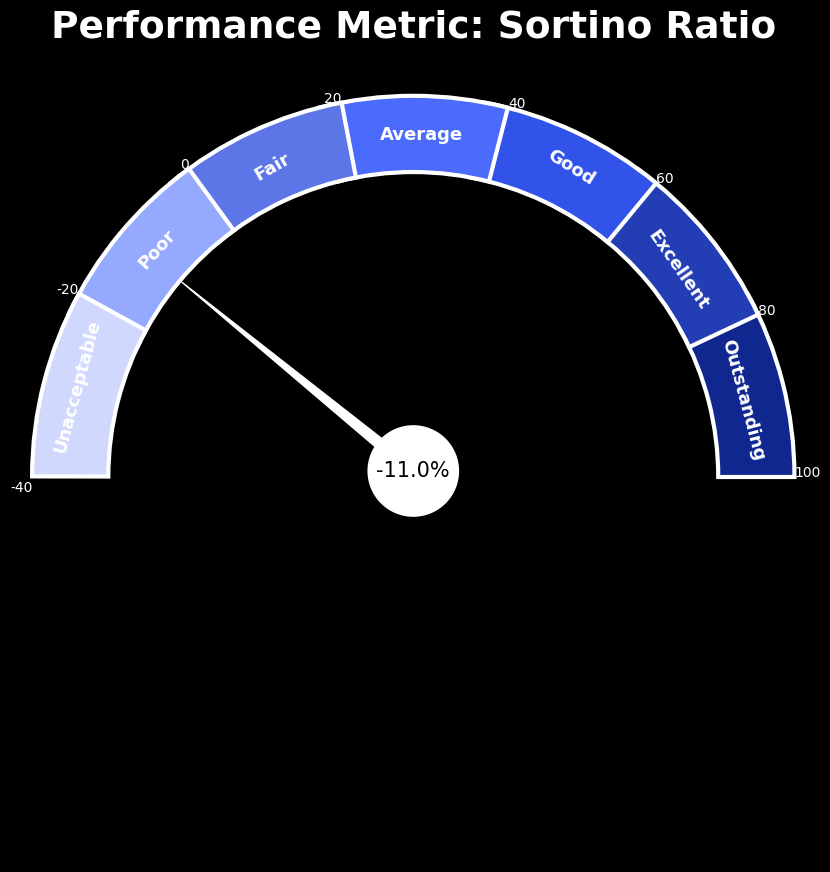

In [103]:
plot_gauge_chart(sortino_ratio, 'Sortino Ratio')

A Sortino ratio of -11% indicates that the trading strategy has underperformed and was inefficient.  
For every unit of capital exposed to bad outcomes(downside volatility), the strategy lost 0.11 units of return.  
With a negative average excess return, the strategy failed to generate positive returns relative to the risk-free rate.

### **4.2.0 Multivariate Analysis: Variables against Metrics**  
This phase of the analysis uses descriptive analytics to understand the past performance of the forex trading strategy, by examining how combinations of features affect metrics.  
This will provide insights into which combination of features resulted in the best performing metrics.

### **4.2.1 Core Strategy VS Metrics**  
The core variables of the BNTP strategy include the features Bias, Profile, Entry, Confirmation.  
A combination of values under these features aligned is what signals a trade entry based on strategy only.  
These features are simultaneously applied for every trade taken.
Their performance against the metrics will be computed to understand how each feature, as well as their combination affected the outcome of trading over the one year period.

In [21]:
# Function to collect metrics for each category
def collect_category_metrics(data: pd.DataFrame, category_column: str, target_column: str) -> pd.DataFrame:
    """
    Collects key performance metrics for each unique category in a specified column.

    This function computes the following metrics for each category:
    Profitability:
    - Gross profit
    - Gross loss
    - Net profit
    - Average win size
    - Average loss size
    - Expectancy
    - Profit factor

    Reliability:
    - Total number of trades
    - Win rate
    - Consecutive winning trades
    - Consecutive losing trades
    - Maximum drawdown

    Args:
        data (pd.DataFrame): The input DataFrame containing trading data.
        category_column (str): The column containing categorical values to group by.
        target_column (str): The column containing profit/loss values.

    Returns:
        pd.DataFrame: A  Multi-indexed DataFrame with the computed metrics for each category.

    Raises:
        TypeError: If input data is not a DataFrame.
        ValueError: If specified columns do not exist in the DataFrame.
    """
    # Data Validation
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input 'data' must be a pandas DataFrame.")
    if category_column not in data.columns or target_column not in data.columns:
        raise ValueError("Specified columns do not exist in the DataFrame.")

    # Initialize list to collect results
    results = []

    # Loop through each unique category
    for category in data[category_column].dropna().unique():
        subset = data[data[category_column] == category]
        
        # Compute performance metrics
        profitability = compute_profitability(subset[target_column])
        gross_profit = profitability['gross_profit'][0]
        gross_loss = abs(profitability['gross_loss'][0])
        net_profit = profitability['net_profit'][0]

        average_sizes = compute_average_sizes(subset[target_column])
        avg_win_size = average_sizes['avg_win_size'][0]
        avg_loss_size = average_sizes['avg_loss_size'][0]
        
              
        total_trades = len(subset)
        win_rate = compute_win_rate(subset['Outcome'])

        trade_streaks = compute_longest_streaks(dataframe['Outcome'])
        win_streak = trade_streaks['win_streak']
        loss_streak = trade_streaks['loss_streak']
        
        max_drawdown = compute_max_drawdown(subset['Balance'])

        sortino_rartio = compute_sortino_ratio(subset['Profit_loss'])

        expectancy = compute_expectancy(
            win_rate, avg_win_size, avg_loss_size
        )
        profit_factor = compute_profit_factor(
            gross_profit=gross_profit,
            gross_loss=gross_loss
        )

        results.append([gross_profit, gross_loss, net_profit,
                        avg_win_size, avg_loss_size, expectancy,
                        profit_factor, total_trades, win_rate,
                        win_streak, loss_streak, max_drawdown, sortino_rartio
                        ])

    # Append results to the list
    columns = pd.MultiIndex.from_tuples(
    [
    ('Profitability', 'Gross profit'),
    ('Profitability', 'Gross loss'),
    ('Profitability', 'Net profit'),
    ('Profitability', 'Average win size'),
    ('Profitability', 'Average loss size'),
    ('Profitability', 'Expectancy'),
    ('Profitability', 'Profit factor'),
    ('Reliability', 'Total trades'),
    ('Reliability', 'Win rate'),
    ('Reliability', 'Consecutive winning trades'),
    ('Reliability', 'Consecutive losing trades'),
    ('Reliability', 'Maximum drawdown'),
    ('Reliability', 'Sortino Ratio')
    ]
    )

    return pd.DataFrame(results, 
                        index=data[category_column].dropna().unique(), 
                        columns=columns)

    

- Performance metrics for **Bias**

In [531]:
# Return performance metrics for each Bias category
bias_metrics = collect_category_metrics(dataframe, 'Bias', 'Profit_loss')
bias_metrics.T

olhc       ohlc
Profitability Gross profit                637.49000  574.87000
              Gross loss                  791.55000  674.42000
              Net profit                 -154.06000  -99.55000
              Average win size             37.50000   44.22000
              Average loss size            21.39000   19.84000
              Expectancy                   -3.13410   -1.26260
              Profit factor                 0.81000    0.85000
Reliability   Total trades                 54.00000   48.00000
              Win rate                      0.31000    0.29000
              Consecutive winning trades    3.00000    3.00000
              Consecutive losing trades    10.00000   10.00000
              Maximum drawdown             -0.14586   -0.12411
              Sortino Ratio                -0.12000   -0.10000

**Inferences on:**

a.) _Profitablity_Metrics_:  
Trades with a bullish bias (olhc) resulted in a loss of $124 over the one year period.  
Bearish bias (ohlc) trades resulted in a slightly higher loss of $129 over the one year period.  

On average bullish bias (olhc) resulted in $37.5 when a trade won, and $21.5 when a trade was a loss.  
Bearish bias (ohlc) on the other hand won $43 on average, and lost $19.7.  

Bullish bias (olhc) yielded expectancy of -$2.3.
Bearish bias (ohlc) yielded expectancy of -$2.  

Bullish bias (olhc) has a profit factor of 0.85.  
Bearish bias (ohlc)  a profit factor of 0.8.  


b.) _Reliability_Metrics_:  
56 of taken trades were in the Bullish (olhc) direction.  
46 were in the Bearish (ohlc) direction.  

Bullish bias (olhc) resulted in a 32% win rate.  
Bearish bias (ohlc) had a 28% win rate.  

Both biases share the same number of consecutive winning trades (3) and losing trades (10).  

Bullish bias (olhc) has a max drawdown of -14.6%.  
Bearish bias (ohlc) has a max drawdown of -12.4%.  

_Conclusion_  
Bullish bias had more winning trades as shown by a slightly higher win rate.  
But their overall performance does not show significant difference.

- Performance metrics for **Profile**

In [91]:
# Return performance metrics for each Profile category
profile_metrics = collect_category_metrics(dataframe, 'Profile', 'Profit_loss')
profile_metrics.T

london reversal  london expansion  \
Profitability Gross profit                      966.60000          0.000000   
              Gross loss                        908.65000         70.420000   
              Net profit                         57.95000        -70.420000   
              Average win size                   48.33000          0.000000   
              Average loss size                  19.33000         23.470000   
              Expectancy                          0.96800        -23.470000   
              Profit factor                       1.06000          0.000000   
Reliability   Total trades                       67.00000          3.000000   
              Win rate                            0.30000          0.000000   
              Consecutive winning trades          3.00000          3.000000   
              Consecutive losing trades          10.00000         10.000000   
              Maximum drawdown                   -0.14586         -0.045838   
              Sortino Ratio                       0.04000         -0.960000   

                                          ny reversal  ny manipulation  
Profitability Gross profit                 165.760000        80.000000  
              Gross loss                   334.000000       152.900000  
              Net profit                  -168.240000       -72.900000  
              Average win size              27.630000        20.000000  
              Average loss size             20.880000        30.580000  
              Expectancy                    -6.327000        -8.324800  
              Profit factor                  0.500000         0.520000  
Reliability   Total trades                  23.000000         9.000000  
              Win rate                       0.300000         0.440000  
              Consecutive winning trades     3.000000         3.000000  
              Consecutive losing trades     10.000000        10.000000  
              Maximum drawdown              -0.103138        -0.044651  
              Sortino Ratio                 -0.350000        -0.210000

**Inferences on:**

a.) _Profitablity_Metrics_:  
London reversal made $57 over the one year period.  
While London expansion,  New York reversal, and New York manipulation yielded losses of $70, $168 and $72 respectively over the one year period.   

London reversal made $48 on average for winning trades, and lost $19 on average.  
London expansion,  New York reversal, and New York manipulation yielded of $0.00, $27 and $20 respectively on average for winning trades.  
In the same order they lost $23.5, $20.9 and $30.6 respectively on average for losing trades.  

London reversal had an expectancy of $0.96.  
London expansion,  New York reversal, and New York manipulation yielded respective expectancies of -$23.5, 	-$6 and -$8.  


London reversal had a profit factor of 1.06.  
London expansion,  New York reversal, and New York manipulation yielded respective profit factors of 0.00,	0.5 and 0.5.  


b.) _Reliability_Metrics_:  
67 trades had London reversal profile.	 
3 trades had London expansion profile.	 
23 trades had New York reversal profile.	 
9 trades had New York manipulation profile.	 

London reversal had a win rate of 30%.  
London expansion,  New York reversal, and New York manipulation yielded respective win rates of %0.00, %30 and %44.  

All profiles share the same number of consecutive winning trades (3) and losing trades (10) on average.  

London reversal had a max drawdown of -14.6%.  
London expansion,  New York reversal, and New York manipulation yielded respective max drawdowns of -4.6%, -10% and -4.5%    

_Conclusion_  
Overall London reversal was the best performing profile.

- Performance metrics for **Entry**

In [92]:
# Return performance metrics for each Entry category
entry_metrics = collect_category_metrics(dataframe, 'Entry', 'Profit_loss')
entry_metrics.T

brkr          ob
Profitability Gross profit                932.60000  279.760000
              Gross loss                  968.67000  497.300000
              Net profit                  -36.07000 -217.540000
              Average win size             42.39000   34.970000
              Average loss size            20.18000   21.620000
              Expectancy                   -0.15760   -6.906600
              Profit factor                 0.96000    0.560000
Reliability   Total trades                 71.00000   31.000000
              Win rate                      0.32000    0.260000
              Consecutive winning trades    3.00000    3.000000
              Consecutive losing trades    10.00000   10.000000
              Maximum drawdown             -0.14586   -0.134249
              Sortino Ratio                -0.02000   -0.280000

**Inferences on:**

a.) _Profitablity_Metrics_:  
Breaker block (brkr) lost $36 over the one year period.  
Order block (ob) lost $217.5 over the one year period.   

Breaker block (brkr) won $42 on average, and lost $20 on average.  
Order block (ob) won $35 on average, and lost $21.6 on average.    

Breaker block (brkr) yielded -$0.15 expectancy.  
Order block (ob) yielded -$7 expectancy.     


Breaker block (brkr) yielded profit factor of 0.96.  
Order block (ob) yielded profit factor of 0.56.  

b.) _Reliability_Metrics_:  
71 trades had Breaker block (brkr) for entry.  
31 trades had Order block (ob) for entry.  	 

Breaker block (brkr) had a win rate of 32%.  
Order block (ob) had a win rate of 26%.    

Both entry types share the same number of consecutive winning trades (3) and losing trades (10) on average.  

Breaker block (brkr) had a -14.6% drawdown.     
Order block (ob) had a -13.4% drawdown.  

_Conclusion_  
Breaker block (brkr) was the better performing entry over the one year period.  

- Performance metrics for **Confirmation**

In [33]:
# Return performance metrics for each Confirmation category
confirmation_metrics = collect_category_metrics(dataframe, 'Confirmation', 'Profit_loss')
confirmation_metrics.T

eq         fvg     vi
Profitability Gross profit                696.45000  459.910000  56.00
              Gross loss                  685.70000  756.270000  24.00
              Net profit                   10.75000 -296.360000  32.00
              Average win size             46.43000   32.850000  56.00
              Average loss size            20.17000   21.010000  24.00
              Expectancy                    0.47600   -5.390600  16.00
              Profit factor                 1.02000    0.610000   2.33
Reliability   Total trades                 49.00000   51.000000   2.00
              Win rate                      0.31000    0.290000   0.50
              Consecutive winning trades    3.00000    3.000000   3.00
              Consecutive losing trades    10.00000   10.000000  10.00
              Maximum drawdown             -0.14078   -0.139105   0.00

**Inferences on:**

a.) _Profitablity_Metrics_:  
Equilibrium (eq) made $10.75 over the one year trading period.  
Fair value gap (fvg) lost the most money; $296.  
Volume imbalance (vi) made $24.  

Equilibrium (eq) won $46.40 on average, and lost $20.2 on average.  
Fair value gap (fvg) won $32.9 on average, and lost $21.  
Volume imbalance (vi) won $56 on average, and lost $24.  

Equilibrium (eq)  yielded profit factor of 1.02.  
Fair value gap (fvg) yielded profit factor of 0.61.  
Volume imbalance (vi) yielded profit factor of 2.33.  

Equilibrium (eq)  yielded $0.48 expectancy.  
Fair value gap (fvg) yielded -$5.40 expectancy.  
Volume imbalance (vi) yielded $16 expectancy.   

b.) _Reliability_Metrics_:  
49 trades had Equilibrium (eq)   for confirmation.  
51 trades had Fair value gap (fvg) for confirmation.  	 
2 trades had Volume imbalance (vi) for confirmation.  

Equilibrium (eq) had a win rate of 31%.  
Fair value gap (fvg) had a win rate of 29%.  
Volume imbalance (vi) had a win rate of 50%.  

All confirmation types share the same number of consecutive winning trades (3) and losing trades (10) on average.  

Equilibrium (eq) had a max drawdown of -14.1%.  
Fair value gap (fvg) had a max drawdown of -1.4%.  
Volume imbalance (vi)  had a max drawdown of 0.00%.  

_Conclusion_  
Volume imbalance performed the best, but had fewer trades to test its viability over a longer period of time.   Equilibrium also significantly outperformed fvg producing a positive expectancy, although meager, and a much higher profit factor.

- Performance metrics for **Fvg_level**

In [ ]:
# Return performance metrics for each Fvg_level category
fvg_level_metrics = collect_category_metrics(dataframe, 'Fvg_level', 'Profit_loss')
fvg_level_metrics.T

low      medium      high
Profitability Gross profit                309.650000  138.260000  12.00000
              Gross loss                  605.070000  127.200000  24.00000
              Net profit                 -295.420000   11.060000 -12.00000
              Average win size             51.610000   23.040000   6.00000
              Average loss size            21.610000   18.170000  24.00000
              Expectancy                   -8.430400    2.435000  -3.90000
              Profit factor                 0.510000    1.090000   0.50000
Reliability   Total trades                 34.000000   14.000000   3.00000
              Win rate                      0.180000    0.500000   0.67000
              Consecutive winning trades    3.000000    3.000000   3.00000
              Consecutive losing trades    10.000000   10.000000  10.00000
              Maximum drawdown             -0.139105   -0.121552  -0.00302

**Inferences on:**

a.) _Profitablity_Metrics_:  
Low fvg retests lost $295.4 over the on year trading period.  
Medium fvg retests made $11.  
High fvg retests lost $12.  

Low fvg retests won $51.60 on average, and lost $21.60 on average.  
Medium fvg retests won $23.00 on average, and lost $18.2.  
High fvg retests won $6 on average, and lost $24.  

Low fvg retests  yielded profit factor of 0.5.  
Fair value gap (fvg) yielded profit factor of 1.09.  
Volume imbalance (vi) yielded profit factor of 0.5.  

Low fvg retests  yielded -$8.4 expectancy.  
Medium fvg retests yielded $2.40 expectancy.  
High fvg retests yielded -$3.9 expectancy.   

b.) _Reliability_Metrics_:  
34 trades had Low fvg retests.  
14 trades had Medium fvg retests.  	 
3 trades had High fvg retests.  

Low fvg retests had a win rate of 18%.  
Medium fvg retests had a win rate of 50%.  
High fvg retests had a win rate of 67%.  

All fvg levels share the same number of consecutive winning trades (3) and losing trades (10) on average.  

Low fvg retests had a max drawdown of -13.9%.  
Medium fvg retests had a max drawdown of -12.2%.  
High fvg retests  had a max drawdown of 0.03%.  

_Conclusion_  
Medium Fvg Levels (3 and 4) appear to have outperformed the other fvg levels.

### **4.2.2 Risk Management VS Metrics**  
This section analyzes how the core risk management variables of the BNTP strategy directly influenced its performance over a one-year period. The analysis focuses on how Stop_loss_pips and Take_profit_pips defined the Risk_to_reward ratio, a critical metric that sets the framework for a trade's potential outcomes. Linking these to Risk_usd, can quantify the profitability and capital preservation of the strategy.  

The Trail_stop feature which moves the stop to break-even and then into profit, aims to reduce Maximum drawdown and increase Average win size by preventing profitable trades from turning into losses. This dynamic management of a trade's risk profile directly affects the Net profit, Expectancy, and Profit factor while simultaneously influencing Win rate and the frequency of Consecutive winning trades. Ultimately, this section provides a data-driven understanding of how each risk management variable shaped the overall success and resilience of the BNTP trading strategy.

- Performance metrics for **Trail_stop**

In [ ]:
# Return performance metrics for each Trail_stop category
trail_stop_metrics = collect_category_metrics(dataframe, 'Trail_stop', 'Profit_loss')
trail_stop_metrics.T

no         yes
Profitability Gross profit                 868.60000  343.760000
              Gross loss                  1463.97000    2.000000
              Net profit                  -595.37000  341.760000
              Average win size              45.72000   31.250000
              Average loss size             20.91000    2.000000
              Expectancy                    -6.91770   28.590000
              Profit factor                  0.59000  171.880000
Reliability   Total trades                  89.00000   13.000000
              Win rate                       0.21000    0.920000
              Consecutive winning trades     3.00000    3.000000
              Consecutive losing trades     10.00000   10.000000
              Maximum drawdown              -0.14586   -0.119666

**Inferences on:**

a.) _Profitablity_Metrics_:  
No trail stop lost $595.37 over the on year trading period.  
Yes trail stop made $341.76.  

No trail stop made $45.72 on average, and lost $20.91 on average.  
Yes trail stop made $31.25 on average, and lost $2.00.  

No trail stop yielded -$6.92 expectancy.  
Yes trail stop yielded $28.59 expectancy.   

No trail stop  yielded profit factor of 0.59.  
Yes trail stop yielded profit factor of 171.88.  
  

b.) _Reliability_Metrics_:  
89 trades did not have a trail stop.  
13 trades had a trail stop

No trail stop had a win rate of 21%.  
Yes trail stop had a win rate of 92%.  

Both conditions share the same number of consecutive winning trades (3) and losing trades (10) on average.  

No trail stop had a max drawdown of -14.6%.  
Yes trail stop had a max drawdown of -11.97%.  

_Conclusion_  
Trailing the stop loss of trades was instrumental to accruing wins significantly.

- Performance metrics for **Stop_loss_pips**

In [54]:
# Return performance metrics for Stop_loss
stop_loss_metrics = collect_category_metrics(dataframe, 'Stop_loss_binned', 'Profit_loss')
stop_loss_metrics.T

above_12_pips  below_10_pips  \
Profitability Gross profit                   365.580000     403.910000   
              Gross loss                     197.020000     988.950000   
              Net profit                     168.560000    -585.040000   
              Average win size                45.700000      26.930000   
              Average loss size               28.150000      19.020000   
              Expectancy                      10.990500      -7.992000   
              Profit factor                    1.860000       0.410000   
Reliability   Total trades                    15.000000      68.000000   
              Win rate                         0.530000       0.240000   
              Consecutive winning trades       3.000000       3.000000   
              Consecutive losing trades       10.000000      10.000000   
              Maximum drawdown                -0.131523      -0.141807   
              Sortino Ratio                    0.400000      -0.410000   

                                          10_to_12_pips  
Profitability Gross profit                   442.870000  
              Gross loss                     280.000000  
              Net profit                     162.870000  
              Average win size                63.270000  
              Average loss size               23.330000  
              Expectancy                       8.712000  
              Profit factor                    1.580000  
Reliability   Total trades                    19.000000  
              Win rate                         0.370000  
              Consecutive winning trades       3.000000  
              Consecutive losing trades       10.000000  
              Maximum drawdown                -0.116906  
              Sortino Ratio                    0.370000

**Inferences on:**

a.) _Profitablity_Metrics_:  
The analysis of Net Profit reveals a clear division in performance, where the two largest stop-loss categories, above_12_pips and 10_to_12_pips, were profitable. The below_10_pips category had severe net loss of $585.04, which supercedes even the sum of the profitable categories when taken in absolute form.     

The profitable categories above_12_pips and 10_to_12_pips boast high average win sizes of $45.70 and $63.27 respectively, providing a substantial margin over their average loss sizes. Conversely, the losing category is defined by a relatively lower average win size of $26.93 which is just shy of a $19.02 average loss.     

Both above_12_pips and 10_to_12_pips show strong positive expectancies, with the former being more efficient per trade at $10.99. In contrast, tighter stop-loss category has significant negative expectancy of $7.99, underpinning the fact that it is an inefficient approach to setting risk.      

The above_12_pips and 10_to_12_pips categories show robust profitability with Profit Factors of 1.86 and 1.58, respectively. In sharp contrast, the tighter stop-loss category has an extremely low Profit Factor of 0.41.     
  

b.) _Reliability_Metrics_:  
the tight stop-loss category accounted for 68 trades executed. This confirms that the strategy was most active in its least efficient stop loss range, resulting in capital erosion through high-frequency losing trades, while the profitable segments are traded far less frequently.  

The most profitable segment, above_12_pips, has the highest win rate at 53%. And 10_to_12_pips
had win rate of 37%. Conversely the unprofitable category, below_10_pips had the lowest win rate of 24%, which is a major contributor to its massive losses. The data confirms that both a favourable risk-to-reward profile and a high win rate are simultaneously achieved only when the stop-loss is sufficiently large.    

Both share the same number of consecutive winning trades (3) and losing trades (10) on average.  

The largest single peak-to-trough capital decline occurred in the infamous below_10_pips category at -14.18%. Nonetheless, the most profitable above_12_pips segment recorded a maximum drawdown of -13.15% which is considerably high, This confirms that the stop-loss sizes that lead to the largest financial losses also correspond to the greatest systemic risk  

_Conclusion_  
This finding strongly suggests a tighter stop loss does not support the strategy's profitability. Rather, the strategy's success is tied to sufficiently large stops (10 or more pips).

- Performance metrics for **Take_profit_pips**

In [55]:
# Return performance metrics for Take_profit_pips
take_profit_metrics = collect_category_metrics(dataframe, 'Take_profit_binned', 'Profit_loss')
take_profit_metrics.T

above_35_pips  below_21_pips  \
Profitability Gross profit                    362.10000     156.190000   
              Gross loss                      321.02000     426.270000   
              Net profit                       41.08000    -270.080000   
              Average win size                 51.73000      22.310000   
              Average loss size                22.93000      20.300000   
              Expectancy                        1.70780      -9.647500   
              Profit factor                     1.13000       0.370000   
Reliability   Total trades                     21.00000      28.000000   
              Win rate                          0.33000       0.250000   
              Consecutive winning trades        3.00000       3.000000   
              Consecutive losing trades        10.00000      10.000000   
              Maximum drawdown                 -0.13143      -0.126952   
              Sortino Ratio                     0.08000      -0.400000   

                                          21_to_35_pips  
Profitability Gross profit                    694.07000  
              Gross loss                      718.68000  
              Net profit                      -24.61000  
              Average win size                 43.38000  
              Average loss size                19.96000  
              Expectancy                        0.30880  
              Profit factor                     0.97000  
Reliability   Total trades                     53.00000  
              Win rate                          0.32000  
              Consecutive winning trades        3.00000  
              Consecutive losing trades        10.00000  
              Maximum drawdown                 -0.14586  
              Sortino Ratio                    -0.02000

**Inferences on:**

a.) _Profitablity_Metrics_:  
Only the above_35_pips range yielded a positive return of $41.08, while the other categories were significant net losers, particularly below_21_pips with a net loss of $270.08. This highlights the attempts to scalp profits are severely detrimental to the strategy's overall performance.     

The profitable above_35_pips segment boasts the highest average win size at $51.73, over two times its loss size indicating a strong risk-to-reward profile. This is followed by the 21_to_35_pips with average win size of $43.38 and a loss size of $19.96.In contrast, the below_21_pips show average win sizes barely larger than its respective average loss, confirming its inability to capture sufficient gains to overcome trade costs.  

The above_35_pips category exhibits the strongest positive expectancy of $1.7. Conversely, the losing category, below_21_pips, show significant negative expectancy of $9.64.  

The profitable above_35_pips category has a Profit Factor of 1.13, and 21_to_35_pips has that of 0.97. Meanwhile, the losing segment has that of 0.37. This extremely low value signifies that for every dollar won, the strategy is losing nearly three dollars, confirming its status as a significant drain on capital.    

b.) _Reliability_Metrics_:  
The volume of trades provides a critical operational insight: the strategy is highly active in its least efficient ranges. The two tightest take-profit ranges accounted for the highest total trade volume, yet these are the categories that contributed the most to the overall net loss of the strategy. This confirms that the high frequency of trading, driven by tight target limits, is precisely what leads to the severe erosion of capital, while the successful, high-expectancy above_35_pips is traded with less frequency.    

All the segments show significantly lower win rates below 35%, with the tightest range (below_21_pips) being the least reliable with 25%. This demonstrates that the optimal strategy requires a critical mass of successful trades combined with large average wins.  

All categories share the same number of consecutive winning trades (3) and losing trades (10) on average.  

The maximum drawdown figures reveal a significant systemic risk across all take-profit settings. All categories show a similar magnitude of peak-to-trough capital decline, clustered between -12.70% and -14.59%. The 21_to_35_pips category recorded the highest drawdown. This indicates significant risk is present regardless of the take-profit target chosen.  

_Conclusion_  
This finding conclusively demonstrates that the strategy's profitability is optimal within a wider take-profit target (26_to_35_pips), while tighter targets are detrimental to overall performance.  
Also a high volume of trades with a low success rate is highly damaging, and is associated with tighter profit targets.

- Performance metrics for **Risk_usd**

In [63]:
# Return performance metrics for Risk_usd
risk_usd_metrics = collect_category_metrics(dataframe, 'Risk_usd_binned', 'Profit_loss')
risk_usd_metrics.T

above_$25   below_$20  $20_to_$25
Profitability Gross profit                359.080000  444.980000  408.300000
              Gross loss                  275.960000  905.410000  284.600000
              Net profit                   83.120000 -460.430000  123.700000
              Average win size             51.300000   26.180000   68.050000
              Average loss size            34.500000   17.750000   23.720000
              Expectancy                    5.826000   -6.328200    6.564100
              Profit factor                 1.300000    0.490000    1.430000
Reliability   Total trades                 15.000000   69.000000   18.000000
              Win rate                      0.470000    0.260000    0.330000
              Consecutive winning trades    3.000000    3.000000    3.000000
              Consecutive losing trades    10.000000   10.000000   10.000000
              Maximum drawdown             -0.120038   -0.141807   -0.138338
              Sortino Ratio                 0.150000   -0.370000    0.290000

**Inferences on:**

a.) _Profitablity_Metrics_:  
The risk categories, above_$25 and $20_to_$25 were the profitable segments, with the latter being the most successful at $123.70. In stark contrast, the below_$20 was a significant net loser, incurring a large loss of $460.43.    

The profitable $20_to_$25 risk range achieved an exceptionally high average win size of $68.05, providing a wide margin over its average loss size of $23.72; almost 3 times the loss size. The above_$25 range also performed well with a win size of $51.30 over a reasonable loss size of $34.50. Conversely, the losing category was severely hampered by small average wins of $26.18 against a loss of $17.75.  

The $20_to_$25 risk category exhibits the strongest positive expectancy of $6.56, indicating it is the most efficient risk segment, followed by above_$25 with $5.83. Conversely, the lower-risk range shows significant negative expectancy of -$6.33 per trade.    

Both profitable categories have a Profit Factor well above 1.0, with the $20_to_$25 range leading with 1.43. Conversely, the lower-risk category is severely unprofitable with a Profit Factor just shy of 0.5, which signifies that its gross losses are more than double its gross profits, demonstrating extreme financial inefficiency in the lower-risk segments.  

b.) _Reliability_Metrics_:  
The unprofitable lower-risk category accounted for the majority of the trade volume, having 69 trades. Conversely the successful, higher-risk categories are traded at less frequency but provided all the profit.  

The profitable above_$24 category has the highest win rate at 47%, and the $20_to_$25 range yielding 33%.The lowest-risk range, has the lowest win rate at a meager 26%, confirming that tightly controlling dollar risk severely compromises the reliability of the trading signals.  

All risk ranges share the same number of consecutive winning trades (3) and losing trades (10) on average.  

The largest drawdown of -14.18% occurred in the lower-risk, highly unprofitable category, indicating that the attempts to reduce dollar risk failed to mitigate erosion of capital. Although, the profitable risk ranges recorded drawdowns between 12-14% as well, suggesting that significant capital risk is inherent across all risk categories.  

_Conclusion_  
To conclude, accepting higher dollar risk ($20 and above) is directly correlated with capturing the large gains necessary for a profitable edge. And a high frequency of trading in the low risk-defined segment erodes capital.  

- Performance metrics for **risk_to_reward**

In [532]:
# Return performance metrics for Stop_loss
rr_metrics = collect_category_metrics(dataframe, 'Risk_to_reward_binned', 'Profit_loss')
rr_metrics.T

above_3.2_rr  2_to_2.6_rr  \
Profitability Gross profit                  276.100000   339.150000   
              Gross loss                    280.000000   607.300000   
              Net profit                     -3.900000  -268.150000   
              Average win size               46.020000    37.680000   
              Average loss size              18.670000    21.690000   
              Expectancy                      0.090100    -7.441200   
              Profit factor                   0.990000     0.560000   
Reliability   Total trades                   21.000000    37.000000   
              Win rate                        0.290000     0.240000   
              Consecutive winning trades      3.000000     3.000000   
              Consecutive losing trades      10.000000    10.000000   
              Maximum drawdown               -0.133891    -0.141807   
              Sortino Ratio                  -0.010000    -0.290000   

                                          2.6_to_3.2_rr   0_to_2_rr  
Profitability Gross profit                   492.000000  105.110000  
              Gross loss                     304.500000  274.170000  
              Net profit                     187.500000 -169.060000  
              Average win size                44.730000   26.280000  
              Average loss size               20.300000   21.090000  
              Expectancy                       8.313200   -9.721200  
              Profit factor                    1.620000    0.380000  
Reliability   Total trades                    27.000000   17.000000  
              Win rate                         0.440000    0.240000  
              Consecutive winning trades       3.000000    3.000000  
              Consecutive losing trades       10.000000   10.000000  
              Maximum drawdown                -0.138338   -0.124204  
              Sortino Ratio                    0.330000   -0.460000

**Inferences on:**

a.) _Profitablity_Metrics_:  
Only the 2.6_to_3.2_rr category yielded a significant net profit of $187.50. In stark contrast, all other R:R categories were net losers, with the 2_to_2.6_rr range incurring the largest loss at -$268.15.    
This key finding establishes that the strategy's success is dependent on achieving a high, specific R:R  

The profitable 2.6_to_3.2_rr category maintains a favorable risk-to-reward profile with a high average win size ($44.73) relative to its loss size. Crucially, the losing categories are all defined by smaller average wins; the 0_to_2_rr category has the lowest average win size ($26.28), making success difficult given its average loss size of $21.09. This confirms that the ability to capture specific, large gains is the primary driver of success  

The 2.6_to_3.2_rr category exhibits a strong positive expectancy of $8.31, indicating a high average profit per trade. Conversely, the 0_to_2_rr and 2_to_2.6_rr categories have highly negative expectancies, confirming their status as significantly losing strategies. The above_3.2_rr category, with a near-zero expectancy of $0.09, demonstrates marginal inefficiency  

The profitable 2.6_to_3.2_rr category has a robust Profit Factor of 1.62. Conversely, the three unprofitable categories are all well below 1.0, with the tightest range, 0_to_2_rr, having the lowest Profit Factor at 0.38. This extremely low value means that its gross losses are nearly three times its gross profits, demonstrating profound financial inefficiency that is directly attributed to trading in the lowest R:R environment.  

b.) _Reliability_Metrics_:  
The two losing R:R categories (2_to_2.6_rr and 0_to_2_rr) accounted for the majority of all trades, with the 2_to_2.6_rr range being the most active and the largest net loser. This confirms that the strategy's high-frequency activity is concentrated in the inefficient segments, which actively erodes capital, while the successful, high-expectancy range is traded less often but yields the most profit.  

The 2.6_to_3.2_rr category achieves the highest win rate at 44%. In sharp contrast, the three unprofitable categories all have significantly lower win rates (24% to 29%), making them unreliable risk to reward ranges for successful trades.

Both conditions share the same number of consecutive winning trades (3) and losing trades (10) on average.  

The largest drawdown was recorded in the highly unprofitable 2_to_2.6_rr category at -14.2%, confirming that the most active losing segment also carried the greatest risk of a single capital correction. The profitable 2.6_to_3.2_rr segment also had a significant drawdown of -13.8%. This suggests that while the optimal R:R ratio drives profitability, it does not mitigate volatility, and significant capital risk is inherent across all high-R:R segments of the strategy.    

_Conclusion_  
The strategy's profitability is entirely dependent on its ability to execute high risk-to-reward trades, while any lower ratio consistently results in significant losses.

### **4.2.3 Time Management VS Metrics**  
This section examines how the BNTP strategy's time management variables influenced its performance over the one-year period.  
By analyzing features such as trade duration, session, and specific time stamps like trade window, day of the week, and month of the year, crucial patterns can be uncovered in the strategy's outcomes.  
The analysis aims to compute how these temporal factors directly affect both profitability and reliability metrics.  
Understanding the interplay between when trades are executed and their subsequent performance is key to identifying periods of optimal performance, and conversely, uncovering specific time-based weaknesses.  
Ultimately, this granular temporal analysis provides a foundational understanding of how the BNTP strategy's success is tied to a temporal context, paving the way for further optimization.

- Performance metrics for **Session**

In [ ]:
# Return performance metrics for each Session category
session_metrics = collect_category_metrics(dataframe, 'Session', 'Profit_loss')
session_metrics.T

ny am       ny pm
Profitability Gross profit                1155.36000   57.000000
              Gross loss                  1145.07000  320.900000
              Net profit                    10.29000 -263.900000
              Average win size              41.26000   28.500000
              Average loss size             19.74000   24.680000
              Expectancy                     0.39000  -17.766600
              Profit factor                  1.01000    0.180000
Reliability   Total trades                  87.00000   15.000000
              Win rate                       0.33000    0.130000
              Consecutive winning trades     3.00000    3.000000
              Consecutive losing trades     10.00000   10.000000
              Maximum drawdown              -0.14586   -0.122266

**Inferences on:**

a.) _Profitablity_Metrics_:  
New York A.M session made $10.29 over the on year trading period.  
New York P.M session lost $263.90.  

New York A.M session made $41.26 on average, and lost $19.74 on average.  
New York P.M session made $28.50 on average, and lost $24.68.  

New York A.M session yielded $0.39 expectancy.  
New York P.M session yielded -$17.77 expectancy.   

New York A.M session yielded profit factor of 1.01.  
New York P.M session yielded profit factor of 0.18.  
  

b.) _Reliability_Metrics_:  
87 trades were taken during New York A.M session.  
15 trades were taken during New York P.M session.  

New York A.M session had a win rate of 33%.  
New York P.M session had a win rate of 13%.  

Both sessions share the same number of consecutive winning trades (3) and losing trades (10) on average.  

New York A.M session had a max drawdown of -14.6%.  
Yes trail stop had a max drawdown of -12.20%.  

_Conclusion_  
New York A.M session resulted in a better performance in making more profit on average, as underpinned mainly by expectancy and profit factor, although profit made was small.

- Performance metrics for **Month**

In [41]:
# Return performance metrics for each Confirmation category
month_metrics = collect_category_metrics(dataframe, 'Month', 'Profit_loss')
month_metrics.T

May        June        July  \
Profitability Gross profit                218.250000   75.110000   32.000000   
              Gross loss                   48.420000  175.750000  122.000000   
              Net profit                  169.830000 -100.640000  -90.000000   
              Average win size             72.750000   18.780000   32.000000   
              Average loss size            24.210000   25.110000   20.330000   
              Expectancy                   33.966000   -9.309600  -13.003800   
              Profit factor                 4.510000    0.430000    0.260000   
Reliability   Total trades                  5.000000   11.000000    7.000000   
              Win rate                      0.600000    0.360000    0.140000   
              Consecutive winning trades    3.000000    3.000000    3.000000   
              Consecutive losing trades    10.000000   10.000000   10.000000   
              Maximum drawdown             -0.126788   -0.040294   -0.024244   

                                              August   September     October  \
Profitability Gross profit                301.500000  172.500000   70.000000   
              Gross loss                  144.600000  179.200000  196.000000   
              Net profit                  156.900000   -6.700000 -126.000000   
              Average win size             43.070000   43.120000   70.000000   
              Average loss size            18.080000   22.400000   19.600000   
              Expectancy                   10.660500   -0.778400  -11.536000   
              Profit factor                 2.090000    0.960000    0.360000   
Reliability   Total trades                 15.000000   12.000000   11.000000   
              Win rate                      0.470000    0.330000    0.090000   
              Consecutive winning trades    3.000000    3.000000    3.000000   
              Consecutive losing trades    10.000000   10.000000   10.000000   
              Maximum drawdown             -0.130981   -0.137594   -0.034884   

                                            November   December     January  \
Profitability Gross profit                218.000000  10.000000    0.000000   
              Gross loss                  102.000000  56.000000  170.000000   
              Net profit                  116.000000 -46.000000 -170.000000   
              Average win size             43.600000  10.000000    0.000000   
              Average loss size            20.400000  18.670000   21.250000   
              Expectancy                   11.600000 -11.502500  -21.250000   
              Profit factor                 2.140000   0.180000    0.000000   
Reliability   Total trades                 10.000000   4.000000    8.000000   
              Win rate                      0.500000   0.250000    0.000000   
              Consecutive winning trades    3.000000   3.000000    3.000000   
              Consecutive losing trades    10.000000  10.000000   10.000000   
              Maximum drawdown             -0.014435  -0.012051   -0.044849   

                                           February      March       April  
Profitability Gross profit                44.000000   0.000000   71.000000  
              Gross loss                  76.000000  80.000000  116.000000  
              Net profit                 -32.000000 -80.000000  -45.000000  
              Average win size            44.000000   0.000000   23.670000  
              Average loss size           19.000000  20.000000   19.330000  
              Expectancy                  -6.400000 -16.000000   -5.140000  
              Profit factor                0.580000   0.000000    0.610000  
Reliability   Total trades                 5.000000   5.000000    9.000000  
              Win rate                     0.200000   0.200000    0.330000  
              Consecutive winning trades   3.000000   3.000000    3.000000  
              Consecutive losing trades   10.000000  10.000000   10.000000  
              M

**Inferences on:**

a.) _Profitablity_Metrics_:  
May and November made the most, respectively, $169.83 and $116.00 over the one year trading period.  
All other months had losses.  

May and October made $72.75 and $70.00 on average for winning trades, indicating periods where the strategy captured large profitable moves.  
Conversely, the data points to severe underperformance in January and March, where the average win size was zero suggesting a complete lack of winning trades.  
Average loss sizes remained relatively stable throughout the year, fluctuating within a narrow range of approximately $18 to $25.  

May, had an expectancy of approximately $34, indicating that the strategy, on average, profited by that amount per trade during that month. Similarly, November and August also showed strong positive expectancy, suggesting these were periods of significant capital growth.   
Conversely, the majority of the remaining months demonstrated a negative expectancy, with January and March showing the most pronounced losses per trade, at -$21.25 and -$16.00 respectively.  

May, stands out with an exceptional profit factor of $4.51. Similarly, August and November, with profit factors above $2.0, were also periods of strong positive performance.  
Conversely, the majority of the year saw profit factors well below $1.0, signifying that total losses consistently exceeded total profits. The months of January and March, with a profit factor of $0.00, are particularly notable, as they indicate that no gross profits were generated in these months, leading to a complete failure to offset any losses.   
  

b.) _Reliability_Metrics_:  
August, September, October show a concentrated period of high trading volume, having 15, 12, and 11 trades respectively.  
On the other hand, trading activity slows down significantly towards the end and beginning of the year, with December, February, and March recording the lowest number of trades; 4, 5, and 5 trades respectively.  
This suggests the strategy tends to be selective in calmer market conditions, when fewer trade setups were available.  


While a few months, such as May and November, demonstrated relatively high success rates; 60% and 50% respectively, the majority of the year saw the win rate fall below 50%.   

There was unchanged number of consecutive winning trades (3) and losing trades (10) on average, year round.  

While the majority of the year saw relatively contained drawdowns, fluctuating between approximately 1% and 4.5%, a few specific months experienced significantly more severe drawdowns. Notably, May, August, and September stand out as periods of elevated risk, with respective drawdowns, 12.7%, 13.1%, and 13.8%.  

_Conclusion_  
It is evident that the strategy's profitability fluctuated dramatically over the course of the year. The most striking observation is the stark contrast between a handful of highly profitable months and several periods of consistent negative returns.  
The extreme volatility in the metrics above underscores a strategy that is not consistently effective; instead, its success hinges on its ability to capitalize on a few favorable market conditions, while proving to be largely unprofitable during other periods.

- Performance metrics for **Day**

In [ ]:
# Return performance metrics for each Day category
day_metrics = collect_category_metrics(dataframe, 'Day', 'Profit_loss')
day_metrics.T

Tuesday      Monday    Thursday  \
Profitability Gross profit                412.880000  123.650000  252.000000   
              Gross loss                  335.760000  142.000000  418.040000   
              Net profit                   77.120000  -18.350000 -166.040000   
              Average win size             51.610000   24.730000   42.000000   
              Average loss size            18.650000   20.290000   23.220000   
              Expectancy                    4.535800   -1.381600   -6.915000   
              Profit factor                 1.230000    0.870000    0.600000   
Reliability   Total trades                 27.000000   12.000000   24.000000   
              Win rate                      0.330000    0.420000    0.250000   
              Consecutive winning trades    3.000000    3.000000    3.000000   
              Consecutive losing trades    10.000000   10.000000   10.000000   
              Maximum drawdown             -0.133984   -0.054567   -0.141807   

                                           Wednesday      Friday  
Profitability Gross profit                144.570000  279.260000  
              Gross loss                  282.170000  288.000000  
              Net profit                 -137.600000   -8.740000  
              Average win size             48.190000   34.910000  
              Average loss size            20.160000   20.570000  
              Expectancy                   -7.857000   -0.597200  
              Profit factor                 0.510000    0.970000  
Reliability   Total trades                 17.000000   22.000000  
              Win rate                      0.180000    0.360000  
              Consecutive winning trades    3.000000    3.000000  
              Consecutive losing trades    10.000000   10.000000  
              Maximum drawdown             -0.126513   -0.139513

**Inferences on:**

a.) _Profitablity_Metrics_:  
Tuesdays made the most with $77.12, being the only profitable trading day, over the on year trading period.  
Fridays lost the least at $8.74.  

Tuesdays made the highest on average at $41.26, and lost $18.65 on average.  
Wednesdays made the second highest $48.19 on average, and lost $20.16.  

Tuesdays yielded the highest expectancy at $4.54 expectancy.  
Fridays yielded the least negative expectancy at -$0.60.   

Tuesdays yielded the highest profit factor of 1.23.  
Fridays yielded second highest profit factor of 0.97.  
  

b.) _Reliability_Metrics_:  
27 trades were taken on Tuesdays. The most traded day.  
24 trades were taken on Thursdays. The second most traded day.  
12 trades were taken on Mondays. The least traded day.  

Monday had the highest win rate of 42%.  
Wednesday had the lowest win rate of 18%.  

All days share the same number of consecutive winning trades (3) and losing trades (10) on average.  

Thursday had the highest max drawdown of -14.18%.  
Monday had the lowest max drawdown of -0.05%.  

_Conclusion_  
Overall Teusday is the trading day that yielded the most profit, had the most trades, and the highest expectancy and profit factor.

- Performance metrics for **Time_window** in UTC

In [ ]:
# Return performance metrics for each time window interval
time_window_metrics = collect_category_metrics(dataframe, 'Time_window', 'Profit_loss')
time_window_metrics.T

12:00-16:00  16:00-20:00
Profitability Gross profit                 1155.36000    57.000000
              Gross loss                   1145.07000   320.900000
              Net profit                     10.29000  -263.900000
              Average win size               41.26000    28.500000
              Average loss size              19.74000    24.680000
              Expectancy                      0.39000   -17.766600
              Profit factor                   1.01000     0.180000
Reliability   Total trades                   87.00000    15.000000
              Win rate                        0.33000     0.130000
              Consecutive winning trades      3.00000     3.000000
              Consecutive losing trades      10.00000    10.000000
              Maximum drawdown               -0.14586    -0.122266
              Sortino Ratio                   0.01000    -0.610000

**Inferences on:**

a.) _Profitablity_Metrics_:  
The strategy's profitable trades appear to be concentrated in the 12:00-16:00 window with a meager performance at $10.29.  
Conversely, the 16:00-20:00 time window has proven to be unprofitable, with a severe loss of -$263.90 .  


The strategy's profitability appears to be driven by trades executed between 12:00-16:00, with average win size of $41.26 which is just twice the loss of $19.74.  
The late-in-the-day trading window 16:00-20:00 on the other hand, had a win size($28.50) almost the same as loss size($24.68), further underpinning its unprofitability.  

The data reveals a positive, but very weak expectancy of $10.29 in the 12:00-16:00 window, signifying in this time window returns were low.  
Contrary, 16:00-20:00 window yielded a staggering negative expectancy of $17.76. This makes trades taken within the late afternoon to evening window highly unattractive, and not worth chasing.  

With a profit factor of 1.01, the expectancy of the 12:00-16:00 window is emphasized.   
And this is similarly portrayed in the 16:00-20:00 range yielding a profit factor of 0.18, which is worse off.  
  

b.) _Reliability_Metrics_:  
The low-profit generating 12:00-16:00 window had the most trades of 87, indicating high-frequency trades and low rewards for risk, were the overarching characteristic of this time window for taken trades.  
However, with just 15 trades, 16:00-20:00 interval's performance is capital-crippling given the large size of the net loss it took.  

The analysis reveals both time windows; 12:00-16:00 and 16:00-20:00 had respective win rates of 33% and 13%, indicating a complete underperformance of the strategy to generate little winning to massively losing trades during those time windows.  


All time windows share the same number of consecutive winning trades (3) and losing trades (10) on average.  

The 12:00-16:00 window captured the higher maximum drawdown of -14.59%.  
This suggests the strategy captured below satisfactory gains during these hours, as well as being susceptible to severe capital declines. The unprofitable late-in-the-day time window also showed a drawdown of -12.2%, indicating high risk is present for the strategy regardless of the time window.  

_Conclusion_  
The analysis reveals that the period with gains, even though small, is also that with the most significant drawdown indicating a high-risk, low-reward dynamic.  

- Performance metrics for **Duration**

In [184]:
# Return performance metrics for trade duration
duration_metrics = collect_category_metrics(dataframe, 'Duration_binned', 'Profit_loss')
duration_metrics.T

above_2_hrs  below_2_hrs
Profitability Gross profit                 575.670000    636.69000
              Gross loss                   118.000000   1347.97000
              Net profit                   457.670000   -711.28000
              Average win size              52.330000     33.51000
              Average loss size             19.670000     20.74000
              Expectancy                    27.130000     -7.72000
              Profit factor                  4.880000      0.47000
Reliability   Total trades                  17.000000     85.00000
              Win rate                       0.650000      0.24000
              Consecutive winning trades     3.000000      3.00000
              Consecutive losing trades     10.000000     10.00000
              Maximum drawdown              -0.133891     -0.14586
              Sortino Ratio                  1.330000     -0.37000

**Inferences on:**

a.) _Profitablity_Metrics_:  
The above_2_hrs duration stands out as the profitable category, yielding a strong net gain of $457.67. In stark contrast, the below_2_hrs duration resulted in a substantial net loss of -$711.28.  
This initial finding establishes that only trades held for longer than two hours contributed positively to the strategy's overall profitability.  


Trades above_2_hrs had an exceptional average win size of $52.33, combined with the lowest average loss size of $19.67. This demonstrates a superior risk-to-reward profile. 

Conversely, the below_2_hrs lasting trades had significantly smaller average wins relative to their average losses, directly contributing to its unprofitability.   

The above_2_hrs duration exhibits a very high positive expectancy of $27.13, indicating that, on average, each trade in this category was highly profitable. This contrasts sharply with below_2_hrs, which shows negative expectancy of  -$7.72, confirms its status as a consistently losing duration on a per-trade basis.   
  
The above_2_hrs duration has an outstanding profit factor of 4.88, signifying that it generated nearly five times more gross profit than gross loss. The below_2_hrs duration, with profit factor 0.47, was demonstrably unprofitable.  



b.) _Reliability_Metrics_:  
above_2_hrs has the lower number of total trades of 17, suggesting a highly selective approach that prioritizes trade quality over quantity. In contrast 72 trades lasted below_2_hrs, yet this is the category that incurred the largest loss.  

The above_2_hrs duration is highly reliable with a 65% win rate, which complements its high profitability. However, below_2_hrs duration's low win rate of 24% is a primary contributor to its significant net loss.  

All time windows share the same number of consecutive winning trades (3) and losing trades (10) on average.  

 The above_2_hrs duration, despite being the most profitable, had a drawdown of -13.39%. However below_2_hrs duration had a worse drawdown of -14.59%, further underpinning its unreliability as a time window to keep a trade in.  

_Conclusion_  
The analysis reveals that severe capital risk associated with high-frequency, low-quality trades was dominant in trades that lasted less than 2 hours. Trades that lasted 2 hours or more has proven to be worth it.

### **4.3.0 Multivariate Analysis: Analysis of the Strategy's Combined Variables against Metrics**  
This section performs deeper analyses of the three major components of the BNTP strategy.  
It will involve the simultaneous analysis of the core variables for the main strategy, risk management and time management against the target metrics.  
This form of analysis is essential since the combination of the variables are implemented in real time when taking a trade. This will lead to the discovery of crucial patterns in the overall strategy's outcomes, identifying periods of optimal performance, and conversely, uncovering specific time-based weaknesses.  
The insights gained from these analyses can be used for optimization, to focus the strategy on the most profitable and reliable combination of variables.

**Composite Score of the Strategy**  
Due to the complexity of combination of the strategy features' metrics, a composite score will be used to rank the combinations.  
This score will provide a single value that reflects the overall performance of the metrics of each strategy combination, allowing for easier comparison and ranking.  

It will be calculated by normalizing and combining the key metrics that reflect both profitability and reliability.  
Profitability will be represented by Net Profit and Profit Factor.  
Reliability will be represented by Maximum Drawdown and Sortino Ratio.  

These variables were selected because they cover the main pillars of robust trading analysis: Return(Net profit), Efficiency(Profit factor) and Risk(Maximum drawdown, Sortino Ratio).  

_Formula_  
Composite Score = Z(Favorable Metrics) - Z(Unfavorable Metrics)  

Favorable Metrics = Z(Net Profit)+Z(Profit Factor)+Z(Sortino Ratio) i.e. (Higher is better)  
Unfavorable Metrics = Z(∣Max Drawdown∣) i.e. (Lower is better)  

Composite Score = Z(Net Profit)+Z(Profit Factor)+Z(Sortino Ratio) - Z(∣Max Drawdown∣)

In [20]:
# Function to compute Composite Score
def compute_composite_scores(data: pd.DataFrame,
                            min_trades: int = 5) -> pd.Series:
    """
    Computes a Composite Score for trading strategies based on profitability and reliability metrics.

    The Composite Score is calculated as:
    Composite Score = Z(Net Profit) + Z(Profit Factor) + Z(Sortino Ratio) - Z(|Max Drawdown|)

    Args:
        data (pd.DataFrame): A DataFrame containing the following columns:
                             'Profit_loss', 'Balance', 'Outcome', 'Strategy_combination'.
        min_trades (int): Minimum number of trades required for a combination to be 
                          considered statistically reliable (default 5).

    Returns:
        pd.DataFrame: A DataFrame with the Composite Score and key metrics for each strategy combination.
    """
    # Data Validation
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input data must be a pandas DataFrame.")
    if data.empty:
        raise ValueError("Input data cannot be empty.")

    # Filter out trade combinations with outcome based on random chance (if it has less than 5 total trades)
    data = data[data[('Reliability', 'Total trades')] > min_trades] 

    # Get combinations from index
    combinations = data.index

    # Standardize metrics
    net_profit_zscore = zscore(data[('Profitability', 'Net profit')])
    profit_factor_zscore = zscore(data[('Profitability', 'Profit factor')])
    sortino_ratio_zscore = zscore(data[('Reliability', 'Sortino Ratio')])
    max_drawdown_zscore = zscore(abs(data[('Reliability', 'Maximum drawdown')]))

    # Calculate Composite Score
    composite_scores = (
        net_profit_zscore + 
        profit_factor_zscore + 
        sortino_ratio_zscore - 
        max_drawdown_zscore
    )
    
    # Sort by Composite Score
    final_ranking = pd.DataFrame(
        {
        'Net profit': data[('Profitability', 'Net profit')],
        'Profit factor': data[('Profitability', 'Profit factor')],
        'Sortino Ratio': data[('Reliability', 'Sortino Ratio')],
        'Maximum drawdown': data[('Reliability', 'Maximum drawdown')],
        'Composite Score': composite_scores  # This is the 5th column
    }, 
    index=combinations
    )

    return final_ranking.sort_values(by='Composite Score', ascending=False)

### **4.3.1 Combination of Core Strategy Features against Metrics**   
A trade is executed based on the variables Bias, Profile, Entry, Confirmation and Fvg_level (if Confirmation is fvg).  
These variables are combined together to result in a trade being worth taking, and no one variable is executed without the others, making their combined analysis crucial.  
This analysis can lead to the insight of which combination of variables resulted in the best performing metrics.

# 

In [16]:
# Isolate strategy columns
strategy = dataframe[['Bias', 'Session', 'Profile', 'Entry', 'Confirmation', 'Fvg_level', 'Outcome', 'Profit_loss', 'Balance', 'Trade_close']].copy()
strategy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Bias          102 non-null    object 
 1   Session       102 non-null    object 
 2   Profile       102 non-null    object 
 3   Entry         102 non-null    object 
 4   Confirmation  102 non-null    object 
 5   Fvg_level     51 non-null     object 
 6   Outcome       102 non-null    object 
 7   Profit_loss   102 non-null    float64
 8   Balance       102 non-null    float64
 9   Trade_close   102 non-null    object 
dtypes: float64(2), object(8)
memory usage: 8.1+ KB


In [17]:
strategy = pd.read_csv('strategy.csv')
strategy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Bias                  102 non-null    object 
 1   Session               102 non-null    object 
 2   Profile               102 non-null    object 
 3   Entry                 102 non-null    object 
 4   Confirmation          102 non-null    object 
 5   Fvg_level             51 non-null     object 
 6   Outcome               102 non-null    object 
 7   Profit_loss           102 non-null    float64
 8   Balance               102 non-null    float64
 9   Strategy_combination  102 non-null    object 
dtypes: float64(2), object(8)
memory usage: 8.1+ KB


In [ ]:
strategy['Strategy_combination'] = strategy['Strategy_combination'].str.replace(' ', '_').str.lower()
strategy['Strategy_combination'].unique()

In [ ]:
strategy_metrics = collect_category_metrics(strategy, 'Strategy_combination', 'Profit_loss')
#strategy_metrics.sort_values(by=('Profitability', 'Net profit'), ascending=False)

In [24]:
# Return summarized strategy_metrics (sorted by Composite score)
strategy_ranking = compute_composite_scores(strategy_metrics)
strategy_ranking[:2]

,Net profit,Profit factor,Sortino Ratio,Maximum drawdown,Composite Score
ny_am_london_reversal_brkr_eq,159.45,1.55,0.35,-0.140780,2.807534
ny_am_london_reversal_ob_eq,32.72,1.41,0.27,-0.134249,1.377058


Upon final ranking, the inferences reveal a fine line between robust strategy combinations and the underperformed ones.  

The top-ranked strategy is **[ny_am_london_reversal_brkr_eq]**  
A net profit of $159.00 and Profit factor of 1.55 demonstrates the edge and efficiency of this strategy combination, proving gross profits prodigiously outweighs gross losses.  
On the downside it yielded the highest maximum drawdown of -14% which assesses risk of ruin and capital preservation, thus in the worst case scenario this combination lost 14% of capital. 
However it is the most statistically reliable and robust for achieving the highest Composite Score and Sortino ratio(which proves the strategy is being rewarded for its downside risk).  

### **4.3.2 Combination of Risk Management Features against Metrics**   
This section, **Combination of Risk Management Features against Metrics**, will analyze the synergic impact of multiple risk management features on overall trading strategy performance. The categorical features Risk_usd_binned, Risk_to_reward_binned, Stop_loss_binned, Take_profit_binned, and the binary Trail_stop will be combined to form unique risk profiles. The simultaneous implementation of these profiles will then be assessed against the performance metrics to identify which combination of risk parameters yields the most robust, profitable, and risk-adjusted strategy outcome.

In [29]:
# Isolate risk management columns
risk_management = dataframe[['Risk_usd_binned', 'Risk_to_reward_binned', 'Stop_loss_binned', 'Take_profit_binned', 'Trail_stop', 'Outcome', 'Profit_loss', 'Balance', 'Trade_close']].copy()
risk_management.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Risk_usd_binned        102 non-null    object 
 1   Risk_to_reward_binned  102 non-null    object 
 2   Stop_loss_binned       102 non-null    object 
 3   Take_profit_binned     102 non-null    object 
 4   Trail_stop             102 non-null    object 
 5   Outcome                102 non-null    object 
 6   Profit_loss            102 non-null    float64
 7   Balance                102 non-null    float64
 8   Trade_close            102 non-null    object 
dtypes: float64(2), object(7)
memory usage: 7.3+ KB


In [30]:
# Feature Engineer strategy columns
risk_management['risk_mgt_combination'] = (
    risk_management['Risk_usd_binned'].astype(str) + '_' +
    risk_management['Risk_to_reward_binned'] + '_' +
    risk_management['Stop_loss_binned'].astype(str) + '_' +
    risk_management['Take_profit_binned'].astype(str) + '_' +
    risk_management['Trail_stop']
)

In [31]:
risk_management['risk_mgt_combination'] = risk_management['risk_mgt_combination'].str.replace(' ', '_').str.lower()
#risk_management['risk_mgt_combination'].unique()

In [ ]:
risk_mgt_metrics = collect_category_metrics(risk_management, 'risk_mgt_combination', 'Profit_loss')
#risk_mgt_metrics.sort_values(by=('Profitability', 'Net profit'), ascending=False)

In [41]:
# Return summarized risk management metrics (sorted by Composite score)
risk_mgt_ranking = compute_composite_scores(risk_mgt_metrics)
risk_mgt_ranking[:3]

,Net profit,Profit factor,Sortino Ratio,Maximum drawdown,Composite Score
$20_to_$25_2_to_2.6_rr_10_to_12_pips_21_to_35_pips_no,-64.00,0.47,-0.44,-0.017389,4.795955
below_$20_2_to_2.6_rr_below_10_pips_below_21_pips_no,-47.55,0.63,-0.27,-0.121020,3.530995
below_$20_2.6_to_3.2_rr_below_10_pips_21_to_35_pips_no,-71.48,0.45,-0.48,-0.106162,1.853319


The top three ranking risk management combinations unanimously resulted in net losses over $60, with their profit factors consistently below 1.0.  
This establishes a clear finding of a negative average expectancy for any strategy employing these specific risk management rules.  
However the top ranker which is **[$20_to_$25_2_to_2.6_rr_10_to_12_pips_21_to_35_pips_no]**, translated as:  
    
    **a dollar risk between $20_to_$25, aiming for a risk to reward between 2_to_2.6, with a stop loss set between 10_to_12_pips, and take profit between 21_to_35_pips, with no trailing stop**  

while it has poor raw returns and efficiency, its relatively low max drawdown of -1.74% heavily rewards its standardized Composite Score, achieving 4.796. This implies even though it resulted in losses, it had the best risk control for capital preservation; the number one priority for investors in the global markets. This combination overcomes as the most stable for managing a relatively smaller risk of ruin from a statistical standpoint.

### **4.3.3 Time Management Features against Metrics**   
This section analyzes how the combination of the temporal variables performed against the metrics.  
For the purpose of this analysis they will be focused on Session, Duration, Time_window, and Day to highlight on a daily basis, the best performing combination since the strategy is of intraday type.
These variables are combined together to find the optimal time a trade is worth taking based on the data, and no one variable is executed without the others.  

In [36]:
# Isolate time management columns
time_management = dataframe[['Day', 'Session', 'Time_window', 'Duration_binned', 'Outcome', 'Profit_loss', 'Balance']].copy()
time_management.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Day              102 non-null    object 
 1   Session          102 non-null    object 
 2   Time_window      102 non-null    object 
 3   Duration_binned  102 non-null    object 
 4   Outcome          102 non-null    object 
 5   Profit_loss      102 non-null    float64
 6   Balance          102 non-null    float64
dtypes: float64(2), object(5)
memory usage: 5.7+ KB


In [37]:
# Feature Engineer time management columns
time_management['time_mgt_combination'] = (
    time_management['Day'] + '_' +
    time_management['Session'] + '_' +
    time_management['Time_window'] + '_' +
    time_management['Duration_binned']
)

In [38]:
time_management['time_mgt_combination'] = time_management['time_mgt_combination'].str.replace(' ', '_').str.lower()
#time_management['time_mgt_combination'].unique()

In [ ]:
time_mgt_metrics = collect_category_metrics(time_management, 'time_mgt_combination', 'Profit_loss')
#time_mgt_metrics.sort_values(by=('Profitability', 'Net profit'), ascending=False)

In [42]:
# Return summarized time management metrics (sorted by Composite score)
time_mgt_ranking = compute_composite_scores(time_mgt_metrics)
time_mgt_ranking[:3]

,Net profit,Profit factor,Sortino Ratio,Maximum drawdown,Composite Score
tuesday_ny_am_12:00-16:00_above_2_hrs,263.10,10.40,3.01,-0.133891,5.956869
monday_ny_am_12:00-16:00_below_2_hrs,-64.35,0.47,-0.32,-0.054567,1.092686
friday_ny_am_12:00-16:00_below_2_hrs,41.26,1.18,0.11,-0.139513,-0.487994


The **[tuesday_ny_am_12:00-16:00_above_2_hrs]** shows significant absolute return and Composite Score, establishing a strong finding that this specific day/time/duration constraint combination captured multiple high-value trades.      

Interestingly, **[monday_ny_am_12:00-16:00_below_2_hrs]** which underperformed compared to **[friday_ny_am_12:00-16:00_below_2_hrs]**, when based on Net Profit, Profit Factor and Sortino ratio, turned out to have a higher Composite Score of 1.09.  
This can be attributed to former having a maximum drawdown just shy of 5.5%, which is less than half that of the latter.   
When the absolute value of the maximum drawdown is standardized and subtracted (−Z(∣Max Drawdown∣)), a high maximum drawdown (like Friday's) results in a much larger penalty than a low maximum drawdown (like Monday's).   
This means the combination for Friday did perform better in generating profits, but is riskier. Whereas Monday's combination resulted in drastic loss, but had a better risk control.



In [73]:
# Function to consolidate the best performances
def consolidate_performances() -> pd.DataFrame:
    # Collect performances
    edges = strategy_ranking[:2]

    survival_mechanism = (
        risk_mgt_ranking.iloc[0]
                        .to_frame()
                        .T
    )
    favorable_environments = time_mgt_ranking.sort_values(by='Net profit', ascending=False)[:2]

 
    new_index = ['edge_1', 'edge_2', 'survival_mechanism', 'favorable_env_1', 'favorable_env_2']
    
    # Consolidate performances into a dataframe
    final_performance = pd.DataFrame(
        data = pd.concat([edges, survival_mechanism, favorable_environments]),
    )
    final_performance.index = new_index

    return final_performance

In [77]:
final_performance = consolidate_performances()

In [108]:
final_performance

,Net profit,Profit factor,Sortino Ratio,Maximum drawdown,Composite Score
edge_1,159.45,1.55,0.35,-0.140780,2.807534
edge_2,32.72,1.41,0.27,-0.134249,1.377058
survival_mechanism,-64.00,0.47,-0.44,-0.017389,4.795955
favorable_env_1,263.10,10.40,3.01,-0.133891,5.956869
favorable_env_2,41.26,1.18,0.11,-0.139513,-0.487994


In [136]:
# Function to visually rank strategy components
def visualize_performances(data: pd.DataFrame) -> None:
    """Generates a two-part plot for presenting the performances of the components of the strategy: Ranked Bar Chart 
       (Composite Score) and a Radar Chart (Multi-Metric Profile).
    """

    # Ranking and Sorting (Best to Worst based on Composite Score)
    data_ranked = data.sort_values(by='Composite Score', ascending=False)
    
    # --- CHART 1: RANKED HORIZONTAL BAR CHART (Composite Score) ---
    plt.figure(figsize=(10, 6))

    # Set the plot background
    plt.style.use('dark_background')

    # color palette
    palette = ["#0f278f", "#3253e9", "#4b6bfd", "#5c75e7", "#d0d8fd"]

    # Create plot
    sns.barplot(
        x='Composite Score', 
        y=data_ranked.index, 
        hue=data_ranked.index,
        data=data_ranked, 
        palette=palette,
        legend=False
    )
    
    plt.title('Overall Ranking by Composite Score', fontsize=19, fontweight='bold')
    plt.xlabel('Composite Score')
    plt.ylabel('Strategy Combination')
    
    # Annotate bars with score values
    for i, (score, name) in enumerate(zip(data_ranked['Composite Score'], data_ranked.index)):
        # Determine position (x_pos) and alignment (alignment)
        if score >= 0:
            # For positive bars, place text inside the bar, aligned left.
            x_pos = score - 0.05  # Slight offset for positive score
            alignment = 'right'
            va='center'
        else:
            x_pos = score - .05
            alignment = 'right'
            va='bottom'

        plt.text(x_pos, i, f'{score:.2f}', va=va, ha=alignment, color='white', fontweight='bold')            

    # Adjust x-limit for both positive and negative labels
    min_score = data_ranked['Composite Score'].min()
    max_score = data_ranked['Composite Score'].max()
    plt.xlim(min_score, max_score * 1.1)
    plt.show()

    # --- CHART 2: RADAR CHART (Multi-Metric Profile) ---
    
    # Set the plot background
    plt.style.use('dark_background')

    # Data Standardization for Radar Chart.
    data_normalized = data_ranked.copy()
    data_normalized['Maximum drawdown'] = data_normalized['Maximum drawdown'] * -1 
    
    # Apply MinMax Scaling to all metrics (0 to 1)
    scaler = MinMaxScaler()
    data_scaled = pd.DataFrame(
        scaler.fit_transform(data_normalized), 
        columns=data_normalized.columns, 
        index=data_normalized.index
    )
    
    # Setup for Radar Plotting
    categories = data_scaled.columns.tolist()
    N = len(categories)
    
    # Create an angle for each category and close the circle
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]    # Repeat the first angle to close the circle

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw axis lines and labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([c.replace(' ', '\n').title() for c in categories], fontsize=12)
    
    # Set y-axis limits and labels
    ax.set_yticks(np.arange(0.25, 1.25, 0.25))
    ax.set_yticklabels(["25%", "50%", "75%", "100%"], color="grey", size=10)
    ax.set_ylim(0, 1)

    # d. Plot each strategy combination's profile
    for i, combination in enumerate(data_scaled.index):
        values = data_scaled.loc[combination].values.flatten().tolist()
        values += values[:1] # Repeat the first value to close the shape
        
        # Use a distinctive color for each profile
        color = plt.cm.viridis(i / len(data_scaled))
        
        # Plot the polyline and fill the area
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=combination, color=color)
        ax.fill(angles, values, color=color, alpha=0.1)

    plt.title('Multi-Metric Performance Profile Comparison (Scaled)', size=18, y=1.1)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3, fancybox=True, shadow=True)
    plt.show()

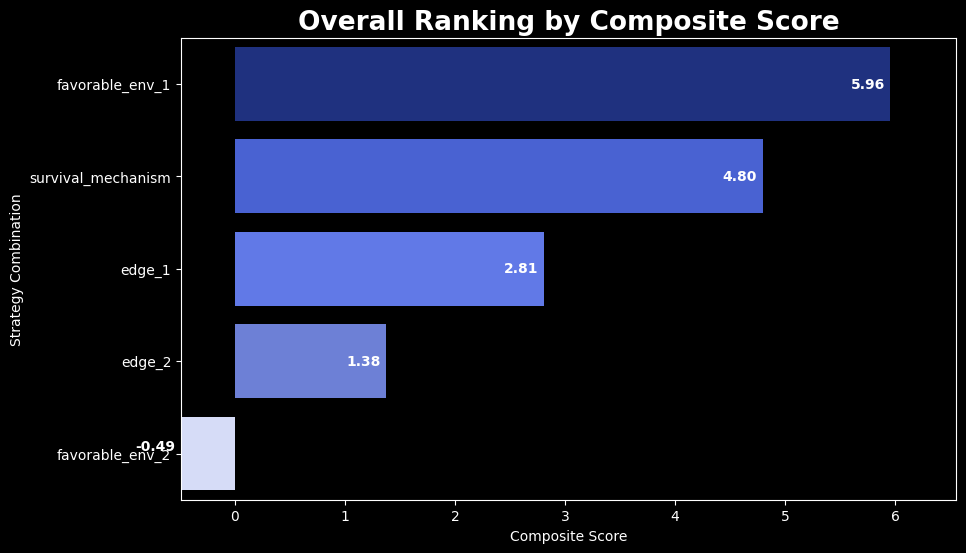

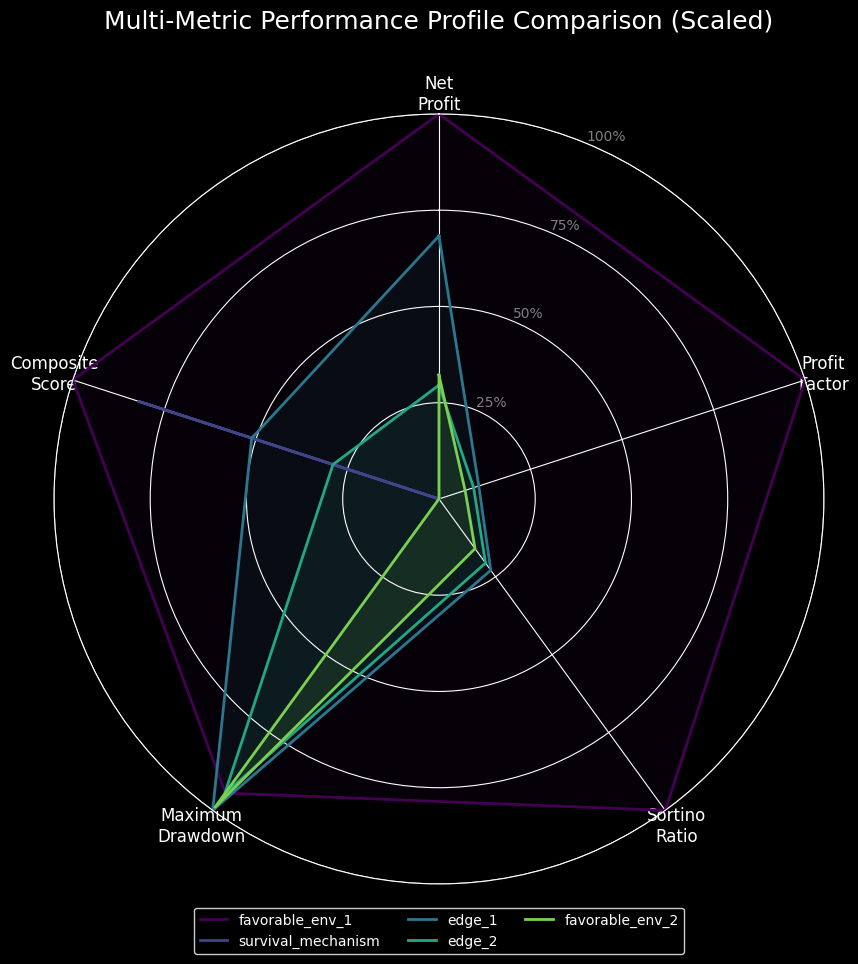

In [137]:
visualize_performances(final_performance)

# **5. CONCLUSION: The Trinity of Performance**   


- **The Edge**  
From the analysis performed above, the best strategy combinations **[ny_am_london_reversal_brkr_eq]**  and **[ny_am_london_reversal_ob_eq]** which provide the edge prove the system logic works, with supporting Profit Factors of 1.55 and 1.41 respectively.  
It appears the combinations are profitable because the market provided a favorable movement more often than not when they enter, resulting in high Net Profits and Profit Factors.  
But under these strategies' universal risk parameters, capital-eroding drawdowns of -14.07% and -13.42% were incurred which introduced unnecessary risk volatilities leading to losses.  


- **The Survival Mechanism**  
The risk management combination **[$20_to_$25_2_to_2.6_rr_10_to_12_pips_21_to_35_pips_no]**, resulted in net loss due to it being applied universally across all trades and strategies, including bad ones. Its tight stop loss may have cut off profitable trades early causing losing trades.  
Regardless it is the most befitting for survival in the market, proving stability is possible. This is underpinned by a relatively lower drawdown of -1.74%.  
Being the most effective at preserving capital, this risk management combination can be used as the base structure for strategy improvement.  
From the analysis of Trailing_stop against metrics, trades that had Trailing_stop accumulated a whopping Profit factor 171.88, while trades without yielded an unsatisfactory 0.59. This makes it more convincing to introduce trailing stops to the risk management combination, in an attempt to further improve risk control while locking in profits.  
This upgrades the risk management combination to:  

        **a dollar risk between $20_to_$25, aiming for a risk to reward between 2_to_2.6, with a stop loss set between 10_to_12_pips, and take profit between 21_to_35_pips, with a trailing stop**


- **The Favorable Environment**  
And the time management combinations which tells when the Edge is statistically strongest and Risk Management template is most effective; **[tuesday_ny_am_12:00-16:00_above_2_hrs]** and **[friday_ny_am_12:00-16:00_below_2_hrs]**, show a high efficiency and reward is achievable with profit factors of 10.40 and 1.18 to support. And the former's Sortino Ratio of 3.01 confirms the profits for it are exceptionally safe and stable against harmful volatility. This indicates time management is the greatest source of performance leverage over the other two performance categories.  
Yet they incurred a relatively high drawdown range of -13 to almost -14%.  
  

The identified edge and favorable environments represent the best statistical parameter setting for the entry condition for a profitable trade.  
And the top ranking survival mechanism is the most efficient at controlling risk.  

The highest ranking strategy combinations hold the capacity to generate systematically proven entries into the market.   
Implementing the risk management combination with a -1.74% drawdown can potentially eliminate unnecessary peak to trough losses.  
The **[tuesday_ny_am_12:00-16:00_above_2_hrs]** has the potential to provide highly rewarding trade entry windows. 

Hence the synergy of these top ranking performance categories into the strategy can be used to generate the best signal, that will maximize trades' profitability and efficiency, while reducing drawdown's impact significantly.  
